__1. Business Problem__

__1.1. Description__

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/
- Data: Memorial Sloan Kettering Cancer Center (MSKCC)
- Download training_variants.zip and training_text.zip from Kaggle.
- Context: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462
- Problem statement: Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

__1.2. Real-world/Business Objectives and Constraints__

- No low-latency requirement.
- Interpretability is important.
- Errors can be very costly.
- Probability of a data-point belonging to each class is needed.

__2. Machine Learning Problem Formulation__

__2.1. Data Overview__

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that human experts/pathologists use to classify the genetic mutations.
- Both these data files are have a common column called ID
- Data file's information:
    - training_variants (ID, Gene, Variations, Class)
    - training_text (ID, Text)

__2.2. Mapping the Real-world Problem to a ML Problem__

__2.2.1. Type of Machine Learning Problem__

There are nine different classes a genetic mutation can be classified into --> multi class classification problem.

__2.2.2. Performance Metric__

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation
- Metric(s):
    - Multi class log-loss
    - Confusion matrix

__2.2.3. Machine Learing Objectives and Constraints__

- Objective: Predict the probability of each data-point belonging to each of the nine classes.
- Constraints:
    - Interpretability
    - Class probabilities are needed.
    - Penalize the errors in class probabilites --> metric is Log-loss.
    - No latency constraints.

__2.3. Train, CV and Test Datasets__

Split the dataset randomly into three parts train, cross validation and test with $64\%$, $16\%$, $20\%$ of data respectively.

__3. Exploratory Data Analysis__

Package

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter, defaultdict

In [3]:
from IPython.display import display

In [4]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [5]:
from nltk.corpus import stopwords

In [6]:
from scipy import sparse

In [7]:
from tqdm import tqdm

In [8]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

In [9]:
import math

In [10]:
import numpy as np

In [11]:
import pandas as pd

In [12]:
import re

In [13]:
import seaborn as sns

Data Reading

In [14]:
data_gv = pd.read_csv(filepath_or_buffer='training/training_variants')
display(data_gv.head())

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [15]:
data_t = pd.read_csv(filepath_or_buffer='training/training_text',
                     sep='\|\|',
                     engine='python',
                     names=['ID', 'TEXT'],
                     skiprows=1)
display(data_t.head())

ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [16]:
print(data_gv.shape)
print(data_t.shape)

(3321, 4)
(3321, 2)


In [17]:
def class_distribution(data, label, title='Data'):
    """
    This function plots the distribution of given data[label].
    """
    class_val_counts = data[label].value_counts().to_frame()
    percents = class_val_counts.apply(lambda x: round((x / data.shape[0]) * 100, 2))
    class_val_counts['Percentage'] = percents
    display(class_val_counts)
    
    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=class_val_counts.index, y=class_val_counts[label])
    for bar in bars.patches:
        bars.annotate(text=format(bar.get_height()),
                      xy=((bar.get_x() + bar.get_width() / 2), bar.get_height()),
                      ha='center',
                      va='center',
                      size=10,
                      xytext=(0, 6),
                      textcoords='offset points')
    plt.xlabel(xlabel=label)
    plt.ylabel(ylabel='Value Counts')
    plt.title(label=title)
    plt.show()

Class  Percentage
7    953       28.70
4    686       20.66
1    568       17.10
2    452       13.61
6    275        8.28
5    242        7.29
3     89        2.68
9     37        1.11
8     19        0.57

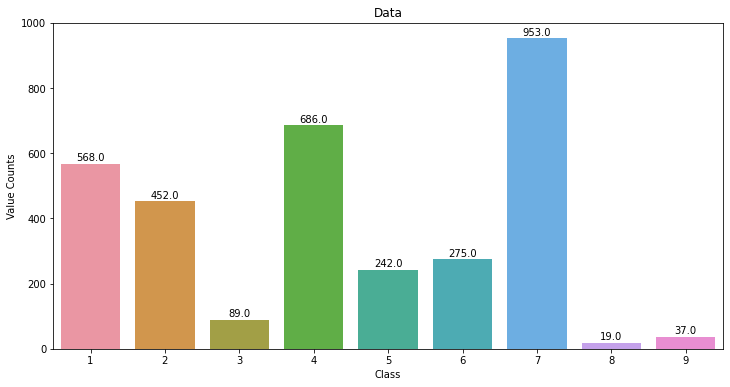

In [18]:
class_distribution(data=data_gv, label='Class')

In [19]:
display(data_gv.isnull().sum())

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [20]:
display(data_t.isnull().sum())

ID      0
TEXT    5
dtype: int64

In [21]:
nan_indices = np.where(data_t['TEXT'].isnull())[0]
print(nan_indices)

[1109 1277 1407 1639 2755]


Basic Text Processing

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
def is_not_stopword(word):
    """
    This function returns `True` if the word is a stopword else `False`.
    """
    return word not in stop_words

In [24]:
def process_text(document):
    """
    This function processes the given document.
        1. Replace special char with a space.
        2. Replace multiple spaces with a single space.
        3. Convert the text into lower.
        4. Split the document string by space.
        5. Filter the words only if they are not in stopwords.
        6. Join the list as string.
    """
    if isinstance(document, str):
        document = re.sub(pattern='[^a-zA-Z0-9\n]', repl=' ', string=document)
        document = re.sub(pattern='\s+', repl=' ', string=document)
        document = document.lower()
        doc_words = document.split()
        doc_filtered_words = list(filter(is_not_stopword, doc_words))
        document = ' '.join(doc_filtered_words)
        return document

In [25]:
documents = list(map(process_text, tqdm(data_t['TEXT'].to_list())))

100%|██████████████████████████████████████████████████████████████| 3321/3321 [00:18<00:00, 175.61it/s]


In [26]:
data_t['TEXT'] = documents

In [27]:
display(data_t.head())

ID                                               TEXT
0   0  cyclin dependent kinases cdks regulate variety...
1   1  abstract background non small cell lung cancer...
2   2  abstract background non small cell lung cancer...
3   3  recent evidence demonstrated acquired uniparen...
4   4  oncogenic mutations monomeric casitas b lineag...

Merge Datasets

In [28]:
results_df = pd.merge(left=data_gv, right=data_t, on='ID', how='left')
display(results_df.head())

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

Replace `NaN` TEXT with Gene and Variation

In [29]:
display(results_df.loc[results_df['TEXT'].isnull()])

ID    Gene             Variation  Class  TEXT
1109  1109   FANCA                S1088F      1  None
1277  1277  ARID5B  Truncating Mutations      1  None
1407  1407   FGFR3                 K508M      6  None
1639  1639    FLT1         Amplification      6  None
2755  2755    BRAF                 G596C      7  None

In [30]:
results_df.loc[results_df['TEXT'].isnull(), 'TEXT'] = results_df['Gene'] + ' ' + results_df['Variation']
display(results_df.iloc[nan_indices])

ID    Gene             Variation  Class                         TEXT
1109  1109   FANCA                S1088F      1                 FANCA S1088F
1277  1277  ARID5B  Truncating Mutations      1  ARID5B Truncating Mutations
1407  1407   FGFR3                 K508M      6                  FGFR3 K508M
1639  1639    FLT1         Amplification      6           FLT1 Amplification
2755  2755    BRAF                 G596C      7                   BRAF G596C

Features and Target

In [31]:
y = results_df['Class'].values
results_df['Gene'] = results_df['Gene'].str.replace('\s+', '_')
results_df['Variation'] = results_df['Variation'].str.replace('\s+', '_')

In [32]:
display(results_df.head())

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating_Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [33]:
train_df, test_df, y_train, y_test = train_test_split(results_df, y, stratify=y, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(train_df, y_train, stratify=y_train, test_size=0.2)

Class  Percentage
7    609       28.67
4    439       20.67
1    363       17.09
2    289       13.61
6    176        8.29
5    155        7.30
3     57        2.68
9     24        1.13
8     12        0.56

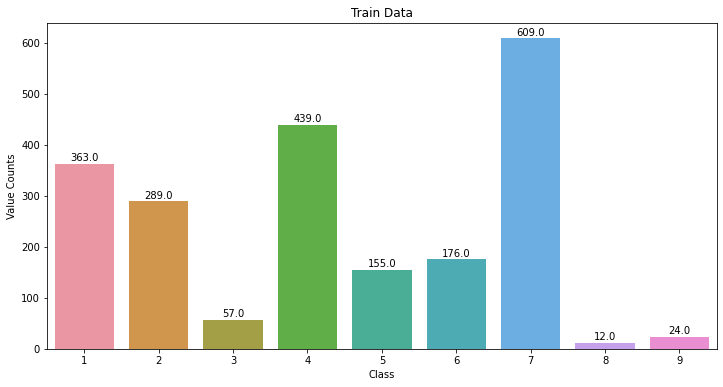

In [34]:
class_distribution(data=train_df, label='Class', title='Train Data')

Class  Percentage
7    153       28.76
4    110       20.68
1     91       17.11
2     72       13.53
6     44        8.27
5     39        7.33
3     14        2.63
9      6        1.13
8      3        0.56

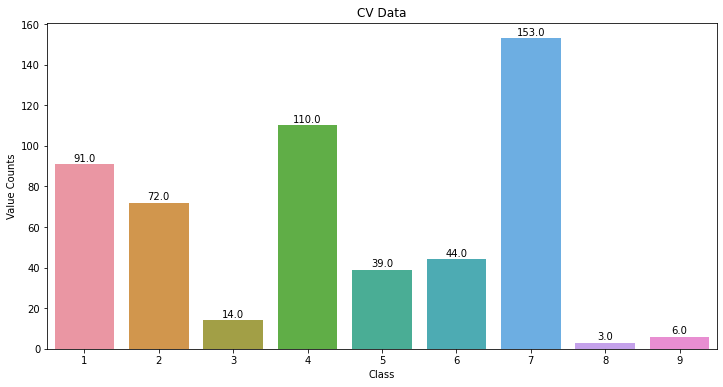

In [35]:
class_distribution(data=cv_df, label='Class', title='CV Data')

Class  Percentage
7    191       28.72
4    137       20.60
1    114       17.14
2     91       13.68
6     55        8.27
5     48        7.22
3     18        2.71
9      7        1.05
8      4        0.60

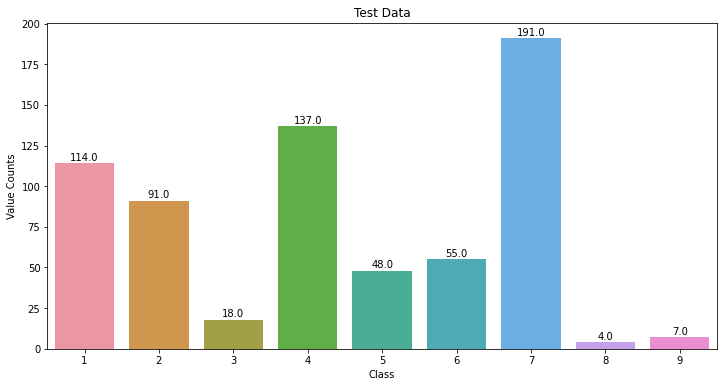

In [36]:
class_distribution(data=test_df, label='Class', title='Test Data')

Confusion Matrix

In [37]:
labels = data_gv.Class.unique()
print(labels)

[1 2 3 4 5 6 7 8 9]


In [38]:
cmat = np.array([[1, 2], [3, 4]])
cmatrix = np.matrix(data=cmat)
print(cmatrix)

[[1 2]
 [3 4]]


Precision Matrix Example

In [39]:
print(cmatrix)
print(cmatrix.sum(axis=0))
pmat = cmatrix / cmatrix.sum(axis=0)
print(pmat)
print(pmat.sum(axis=0))

[[1 2]
 [3 4]]
[[4 6]]
[[0.25       0.33333333]
 [0.75       0.66666667]]
[[1. 1.]]


Recall Matrix Example

In [40]:
print(cmatrix)
print(cmatrix.sum(axis=1))
rmat = cmatrix / cmatrix.sum(axis=1)
print(rmat)
print(rmat.sum(axis=1))

print()

print(cmatrix)
print(cmatrix.T)
print(cmatrix.sum(axis=1))
print(cmatrix.sum(axis=1).T)
print(cmatrix.T / cmatrix.sum(axis=1).T)
rmat = ((cmatrix.T) / (cmatrix.sum(axis=1).T)).T
print(rmat)
print(rmat.sum(axis=1))

[[1 2]
 [3 4]]
[[3]
 [7]]
[[0.33333333 0.66666667]
 [0.42857143 0.57142857]]
[[1.]
 [1.]]

[[1 2]
 [3 4]]
[[1 3]
 [2 4]]
[[3]
 [7]]
[[3 7]]
[[0.33333333 0.42857143]
 [0.66666667 0.57142857]]
[[0.33333333 0.66666667]
 [0.42857143 0.57142857]]
[[1.]
 [1.]]


In [41]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    """
    plt.figure(figsize=(14, 7))
    sns.heatmap(data=matrix,
                annot=True,
                fmt='.2f',
                linewidths=0.1,
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(label=title)
    plt.show()

In [42]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    pmat = cmat / cmat.sum(axis=0) # axis = 0: consider all the rows in each column
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T)/(cmat.sum(axis=1).T)).T # axis = 1: consider all the columns in each row
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)

Random Model

In [43]:
def build_random_model(train_df, cv_df, test_df, labels):
    """
    This function builds the random model.
    """
    y_train = train_df['Class'].values
    X_train = train_df.drop(columns=['Class'])
    
    y_cv = cv_df['Class'].values
    X_cv = cv_df.drop(columns=['Class'])
    
    y_test = test_df['Class'].values
    X_test = test_df.drop(columns=['Class'])
    
    dummy_clf = DummyClassifier(strategy='uniform')
    dummy_clf.fit(X=X_train, y=y_train)
    
    prob_pred_train = dummy_clf.predict_proba(X=X_train)
    train_log_loss = log_loss(y_true=y_train, y_pred=prob_pred_train, eps=1e-15)
    pred_train = dummy_clf.predict(X=X_train)
    
    prob_pred_cv = dummy_clf.predict_proba(X=X_cv)
    cv_log_loss = log_loss(y_true=y_cv, y_pred=prob_pred_cv, eps=1e-15)
    pred_cv = dummy_clf.predict(X=X_cv)
    
    prob_pred_test = dummy_clf.predict_proba(X=X_test)
    test_log_loss = log_loss(y_true=y_test, y_pred=prob_pred_test, eps=1e-15)
    pred_test = dummy_clf.predict(X=X_test)
    
    print("Train")
    print("Log Loss (Train): {}".format(train_log_loss))
    plot_confusion_matrix(y_true=y_train, y_pred=pred_train, labels=labels)
    print(classification_report(y_true=y_train, y_pred=pred_train))
    
    print("\nCross Validation")
    print("Log Loss (CV): {}".format(cv_log_loss))
    plot_confusion_matrix(y_true=y_cv, y_pred=pred_cv, labels=labels)
    print(classification_report(y_true=y_cv, y_pred=pred_cv))
    
    print("\nTest")
    print("Log Loss (Test): {}".format(test_log_loss))
    plot_confusion_matrix(y_true=y_test, y_pred=pred_test, labels=labels)
    print(classification_report(y_true=y_test, y_pred=pred_test))
    
    return pred_train, pred_cv, pred_test

Train
Log Loss (Train): 2.1972245773362196
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


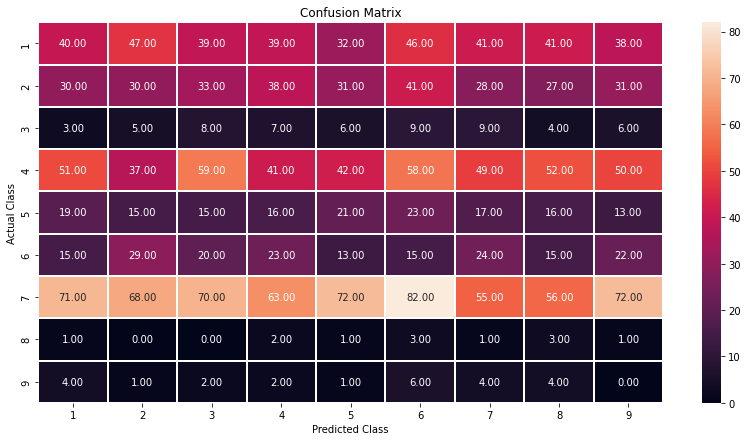

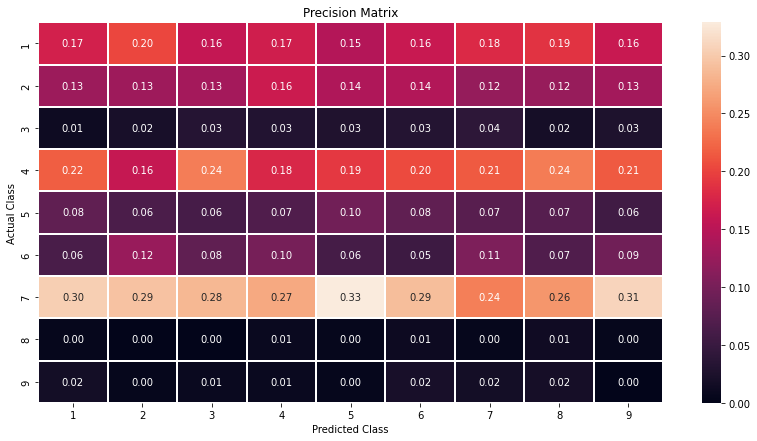

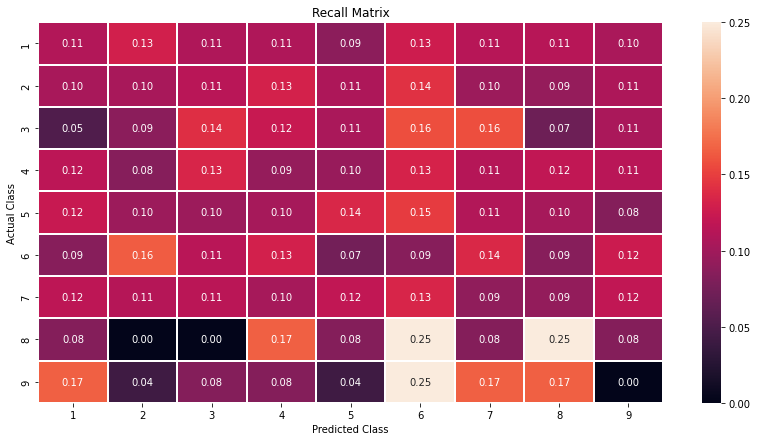

              precision    recall  f1-score   support

           1       0.17      0.11      0.13       363
           2       0.13      0.10      0.12       289
           3       0.03      0.14      0.05        57
           4       0.18      0.09      0.12       439
           5       0.10      0.14      0.11       155
           6       0.05      0.09      0.07       176
           7       0.24      0.09      0.13       609
           8       0.01      0.25      0.03        12
           9       0.00      0.00      0.00        24

    accuracy                           0.10      2124
   macro avg       0.10      0.11      0.08      2124
weighted avg       0.16      0.10      0.12      2124


Cross Validation
Log Loss (CV): 2.1972245773362196
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


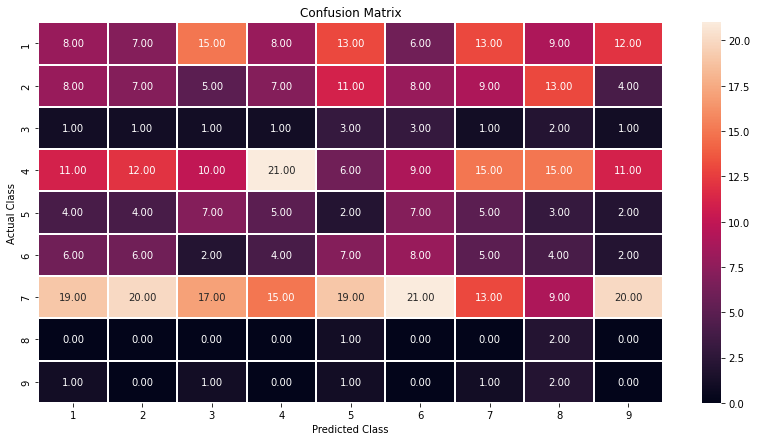

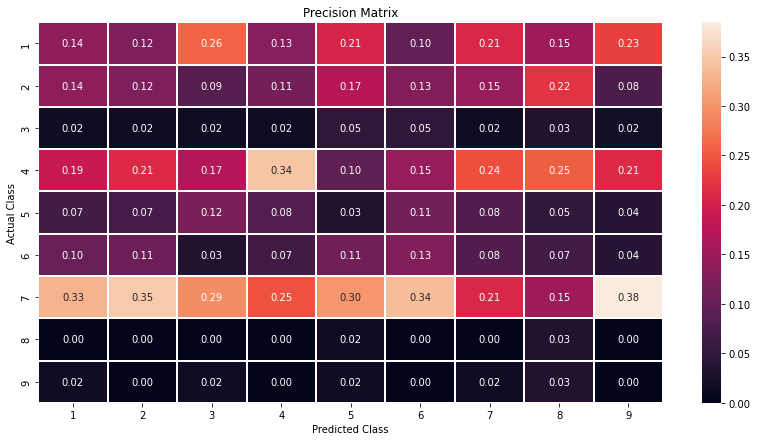

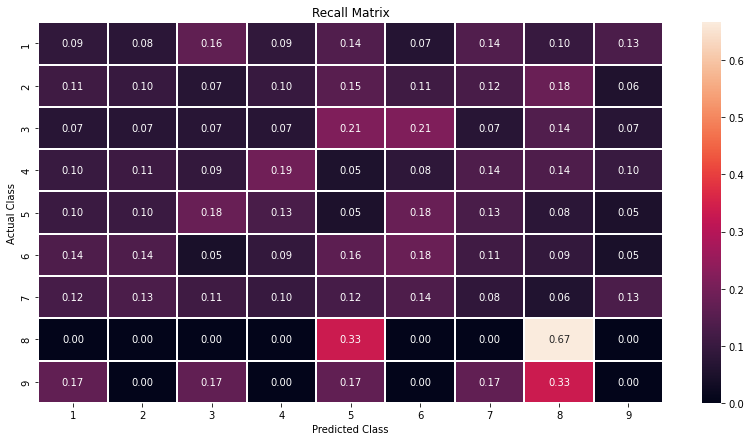

              precision    recall  f1-score   support

           1       0.14      0.09      0.11        91
           2       0.12      0.10      0.11        72
           3       0.02      0.07      0.03        14
           4       0.34      0.19      0.25       110
           5       0.03      0.05      0.04        39
           6       0.13      0.18      0.15        44
           7       0.21      0.08      0.12       153
           8       0.03      0.67      0.06         3
           9       0.00      0.00      0.00         6

    accuracy                           0.12       532
   macro avg       0.11      0.16      0.10       532
weighted avg       0.19      0.12      0.14       532


Test
Log Loss (Test): 2.1972245773362196
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


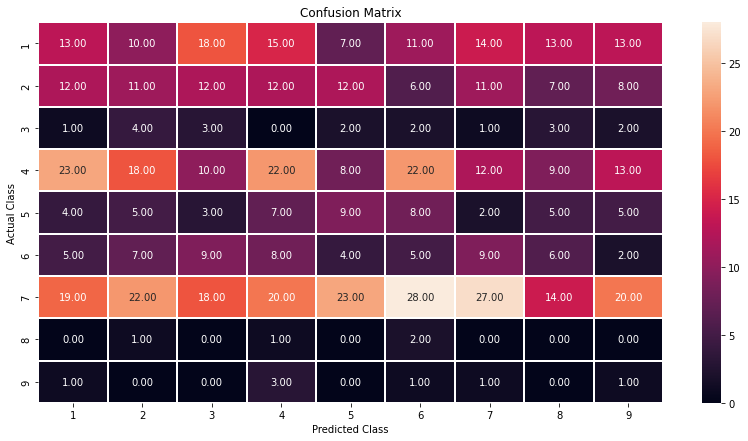

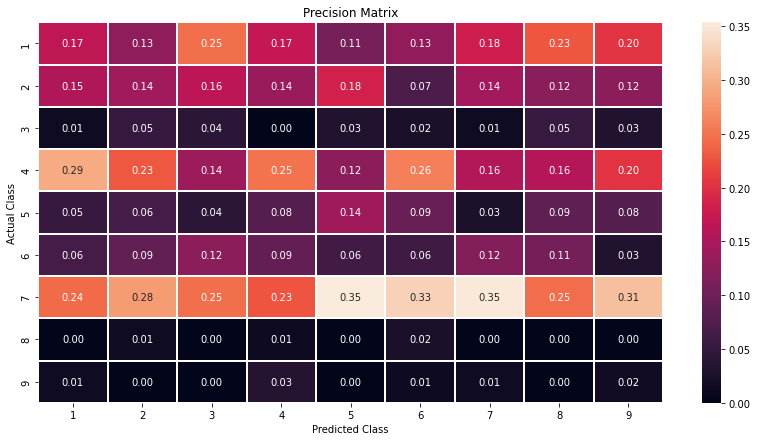

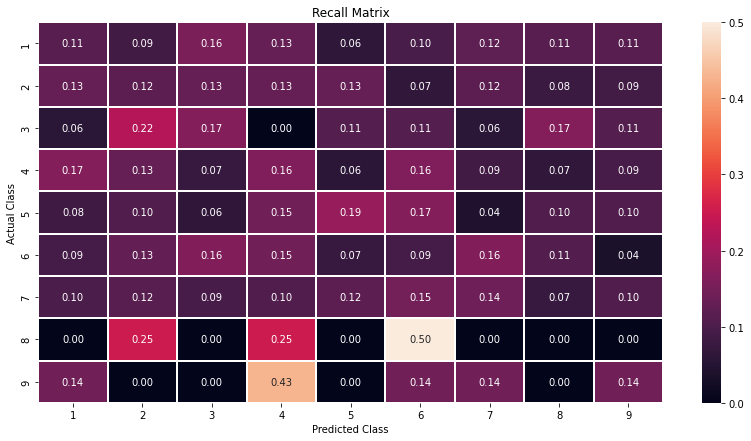

              precision    recall  f1-score   support

           1       0.17      0.11      0.14       114
           2       0.14      0.12      0.13        91
           3       0.04      0.17      0.07        18
           4       0.25      0.16      0.20       137
           5       0.14      0.19      0.16        48
           6       0.06      0.09      0.07        55
           7       0.35      0.14      0.20       191
           8       0.00      0.00      0.00         4
           9       0.02      0.14      0.03         7

    accuracy                           0.14       665
   macro avg       0.13      0.12      0.11       665
weighted avg       0.22      0.14      0.16       665



In [44]:
train_preds, cv_preds, test_preds = build_random_model(train_df=train_df,
                                                       cv_df=cv_df,
                                                       test_df=test_df,
                                                       labels=labels)

Response Coding

In [45]:
class ResponseCoding(object):
    """
    This class is responsible for response coding.
    """
    
    def __init__(self, train_df, cv_df, test_df, df_cols, t_col, alpha=1, factor=10):
        self.train_df = train_df
        self.cv_df = cv_df
        self.test_df = test_df
        self.df_cols = df_cols
        self.t_col = t_col
        self.unique_targets = pd.unique(values=self.train_df[self.t_col])
        self.alpha = alpha
        self.factor = factor
        self.k = len(self.unique_targets)
    
    def perform_response_coding_on_column(self, col, df, laplace=False):
        """
        This method performs response coding on a given column and dataframe.
        """
        col_df = pd.DataFrame()
        total_dict = self.train_df[col].value_counts().to_dict()
        t_col_wise_dict = self.train_df[[col, self.t_col]].value_counts().to_dict()
        if df == 'test':
            df = self.test_df
        elif df == 'cv':
            df = self.cv_df
        else:
            df = self.train_df
        for t_val in self.unique_targets:
            t_list = list()
            for c_val in df[col]:
                try:
                    if c_val not in total_dict.keys():
                        if laplace:
                            add_val = self.alpha * self.factor
                            n_val = (1 + add_val)
                            d_val = self.k + (add_val * self.k)
                            f_val = n_val / d_val
                        else:
                            f_val = 1 / self.k
                        t_list.append(f_val)
                    else:
                        if laplace:
                            add_val = self.alpha * self.factor
                            n_val = t_col_wise_dict[(c_val, t_val)] + add_val
                            d_val = total_dict[c_val] + (add_val * self.k)
                            f_val = n_val / d_val
                        else:
                            f_val = t_col_wise_dict[(c_val, t_val)] / total_dict[c_val]
                        t_list.append(f_val)
                except KeyError as ke:
                    t_list.append(0)
            col_df[col+'_'+str(t_val)] = t_list
        return col_df
    
    def perform_response_coding(self, df, laplace):
        """
        This method performs response coding for an entire dataframe.
        """
        dfs = list()
        for col in self.df_cols:
            col_df = self.perform_response_coding_on_column(col=col, df=df, laplace=laplace)
            dfs.append(col_df)
        rc_df = pd.concat(dfs, axis=1)
        return rc_df

In [46]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Gene'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=False).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=False).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=False).head())

Encoded train data.


Gene_7    Gene_6    Gene_4    Gene_2    Gene_1    Gene_3    Gene_5  \
0  0.527778  0.111111  0.000000  0.111111  0.138889  0.000000  0.111111   
1  0.500000  0.250000  0.000000  0.250000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.500000  0.000000  0.500000  0.000000  0.000000   
3  0.491525  0.033898  0.016949  0.355932  0.000000  0.016949  0.084746   
4  0.000000  0.125000  0.000000  0.000000  0.625000  0.000000  0.250000   

   Gene_8  Gene_9  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     0.0     0.0  
4     0.0     0.0

Encoded cv data.


Gene_7    Gene_6    Gene_4    Gene_2    Gene_1    Gene_3    Gene_5  \
0  0.588235  0.058824  0.000000  0.264706  0.000000  0.000000  0.088235   
1  0.461538  0.000000  0.115385  0.307692  0.000000  0.000000  0.115385   
2  0.000000  0.240000  0.360000  0.000000  0.280000  0.000000  0.120000   
3  0.000000  0.000000  0.461538  0.000000  0.307692  0.076923  0.153846   
4  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111   

     Gene_8    Gene_9  
0  0.000000  0.000000  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.000000  0.000000  
4  0.111111  0.111111

Encoded test data.


Gene_7    Gene_6    Gene_4    Gene_2    Gene_1    Gene_3    Gene_5  \
0  0.000000  0.000000  0.500000  0.000000  0.500000  0.000000  0.000000   
1  0.000000  0.180233  0.186047  0.000000  0.232558  0.058140  0.343023   
2  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
3  0.631579  0.000000  0.000000  0.157895  0.000000  0.105263  0.052632   
4  0.000000  0.000000  0.666667  0.000000  0.000000  0.333333  0.000000   

     Gene_8  Gene_9  
0  0.000000     0.0  
1  0.000000     0.0  
2  0.000000     0.0  
3  0.052632     0.0  
4  0.000000     0.0

In [47]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Gene'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=True).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=True).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=True).head())

Encoded train data.


Gene_7    Gene_6    Gene_4    Gene_2    Gene_1    Gene_3    Gene_5  \
0  0.230159  0.111111  0.000000  0.111111  0.119048  0.000000  0.111111   
1  0.127660  0.117021  0.000000  0.117021  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.198276  0.000000  0.198276  0.000000  0.000000   
3  0.261745  0.080537  0.073826  0.208054  0.000000  0.073826  0.100671   
4  0.000000  0.112245  0.000000  0.000000  0.153061  0.000000  0.122449   

   Gene_8  Gene_9  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     0.0     0.0  
4     0.0     0.0

Encoded cv data.


Gene_7    Gene_6    Gene_4    Gene_2    Gene_1    Gene_3    Gene_5  \
0  0.241935  0.096774  0.000000  0.153226  0.000000  0.000000  0.104839   
1  0.189655  0.000000  0.112069  0.155172  0.000000  0.000000  0.112069   
2  0.000000  0.139130  0.165217  0.000000  0.147826  0.000000  0.113043   
3  0.000000  0.000000  0.155340  0.000000  0.135922  0.106796  0.116505   
4  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111   

     Gene_8    Gene_9  
0  0.000000  0.000000  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.000000  0.000000  
4  0.111111  0.111111

Encoded test data.


Gene_7    Gene_6    Gene_4    Gene_2    Gene_1    Gene_3    Gene_5  \
0  0.000000  0.000000  0.198276  0.000000  0.198276  0.000000  0.000000   
1  0.000000  0.156489  0.160305  0.000000  0.190840  0.076336  0.263359   
2  0.000000  0.000000  0.139785  0.000000  0.000000  0.000000  0.000000   
3  0.201835  0.000000  0.000000  0.119266  0.000000  0.110092  0.100917   
4  0.000000  0.000000  0.161616  0.000000  0.000000  0.131313  0.000000   

     Gene_8  Gene_9  
0  0.000000     0.0  
1  0.000000     0.0  
2  0.000000     0.0  
3  0.100917     0.0  
4  0.000000     0.0

In [48]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Variation'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=False).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=False).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=False).head())

Encoded train data.


Variation_7  Variation_6  Variation_4  Variation_2  Variation_1  \
0          1.0     0.000000     0.000000     0.000000     0.000000   
1          0.0     1.000000     0.000000     0.000000     0.000000   
2          0.0     0.000000     1.000000     0.000000     0.000000   
3          0.0     0.000000     0.000000     1.000000     0.000000   
4          0.0     0.019231     0.019231     0.019231     0.942308   

   Variation_3  Variation_5  Variation_8  Variation_9  
0          0.0          0.0          0.0          0.0  
1          0.0          0.0          0.0          0.0  
2          0.0          0.0          0.0          0.0  
3          0.0          0.0          0.0          0.0  
4          0.0          0.0          0.0          0.0

Encoded cv data.


Variation_7  Variation_6  Variation_4  Variation_2  Variation_1  \
0     0.111111     0.111111     0.111111     0.111111     0.111111   
1     1.000000     0.000000     0.000000     0.000000     0.000000   
2     0.111111     0.111111     0.111111     0.111111     0.111111   
3     0.111111     0.111111     0.111111     0.111111     0.111111   
4     0.000000     0.020000     0.240000     0.000000     0.740000   

   Variation_3  Variation_5  Variation_8  Variation_9  
0     0.111111     0.111111     0.111111     0.111111  
1     0.000000     0.000000     0.000000     0.000000  
2     0.111111     0.111111     0.111111     0.111111  
3     0.111111     0.111111     0.111111     0.111111  
4     0.000000     0.000000     0.000000     0.000000

Encoded test data.


Variation_7  Variation_6  Variation_4  Variation_2  Variation_1  \
0     0.111111     0.111111     0.111111     0.111111     0.111111   
1     0.111111     0.111111     0.111111     0.111111     0.111111   
2     0.000000     0.019231     0.019231     0.019231     0.942308   
3     0.111111     0.111111     0.111111     0.111111     0.111111   
4     0.111111     0.111111     0.111111     0.111111     0.111111   

   Variation_3  Variation_5  Variation_8  Variation_9  
0     0.111111     0.111111     0.111111     0.111111  
1     0.111111     0.111111     0.111111     0.111111  
2     0.000000     0.000000     0.000000     0.000000  
3     0.111111     0.111111     0.111111     0.111111  
4     0.111111     0.111111     0.111111     0.111111

In [49]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Variation'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=True).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=True).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=True).head())

Encoded train data.


Variation_7  Variation_6  Variation_4  Variation_2  Variation_1  \
0     0.120879     0.000000     0.000000     0.000000     0.000000   
1     0.000000     0.120879     0.000000     0.000000     0.000000   
2     0.000000     0.000000     0.120879     0.000000     0.000000   
3     0.000000     0.000000     0.000000     0.120879     0.000000   
4     0.000000     0.077465     0.077465     0.077465     0.415493   

   Variation_3  Variation_5  Variation_8  Variation_9  
0          0.0          0.0          0.0          0.0  
1          0.0          0.0          0.0          0.0  
2          0.0          0.0          0.0          0.0  
3          0.0          0.0          0.0          0.0  
4          0.0          0.0          0.0          0.0

Encoded cv data.


Variation_7  Variation_6  Variation_4  Variation_2  Variation_1  \
0     0.111111     0.111111     0.111111     0.111111     0.111111   
1     0.120879     0.000000     0.000000     0.000000     0.000000   
2     0.111111     0.111111     0.111111     0.111111     0.111111   
3     0.111111     0.111111     0.111111     0.111111     0.111111   
4     0.000000     0.078571     0.157143     0.000000     0.335714   

   Variation_3  Variation_5  Variation_8  Variation_9  
0     0.111111     0.111111     0.111111     0.111111  
1     0.000000     0.000000     0.000000     0.000000  
2     0.111111     0.111111     0.111111     0.111111  
3     0.111111     0.111111     0.111111     0.111111  
4     0.000000     0.000000     0.000000     0.000000

Encoded test data.


Variation_7  Variation_6  Variation_4  Variation_2  Variation_1  \
0     0.111111     0.111111     0.111111     0.111111     0.111111   
1     0.111111     0.111111     0.111111     0.111111     0.111111   
2     0.000000     0.077465     0.077465     0.077465     0.415493   
3     0.111111     0.111111     0.111111     0.111111     0.111111   
4     0.111111     0.111111     0.111111     0.111111     0.111111   

   Variation_3  Variation_5  Variation_8  Variation_9  
0     0.111111     0.111111     0.111111     0.111111  
1     0.111111     0.111111     0.111111     0.111111  
2     0.000000     0.000000     0.000000     0.000000  
3     0.111111     0.111111     0.111111     0.111111  
4     0.111111     0.111111     0.111111     0.111111

Model

In [50]:
def build_model(X_train, X_cv, X_test, y_train, y_cv, y_test, loss, alpha_params):
    """
    This function builds the model.
    """
    log_error_list = list()
    loss_df = pd.DataFrame()
    
    for alpha_i in alpha_params:
        clf = SGDClassifier(alpha=alpha_i, loss=loss, random_state=42)
        clf.fit(X=X_train, y=y_train)
        
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        
        cv_pred = sig_clf.predict_proba(X=X_cv)
        cv_l = log_loss(y_true=y_cv, y_pred=cv_pred)
        log_error_list.append(cv_l)
    
    print("Hyperparameter Tuning")
    loss_df['alpha'] = alpha_params
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss_df['alpha'], loss_df['logloss'], c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(text=(alpha_params[i], txt), xy=(alpha_params[i], log_error_list[i]))
    plt.title(label='CV Error vs Alpha')
    plt.xlabel(xlabel='Alpha')
    plt.ylabel(ylabel='Error')
    plt.grid()
    plt.show()
    
    b_alpha_i = np.argmin(a=log_error_list)
    clf = SGDClassifier(alpha=alpha_params[b_alpha_i], penalty='l2', loss=loss, random_state=42)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best alpha: {}".format(train_loss, alpha_params[b_alpha_i]))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best alpha: {}".format(cv_loss, alpha_params[b_alpha_i]))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best alpha: {}".format(test_loss, alpha_params[b_alpha_i]))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))

Univariate Analysis on Gene Feature

Questions

1. Gene, what type of feature is it?
2. How many categories are there? How are they distributed?
3. How to featurize the Gene feature?
4. How good is this Gene feaure in predicting the Class label?
5. Is Gene feature stable across the data sets (Train, Test, and Validation)?

1. Gene, what type of feature is it?
    - Gene feature is categorical feature.

2. How many categories are there? How are they distributed?

In [51]:
unique_genes = train_df['Gene'].value_counts().to_frame()
print(unique_genes.shape)
display(unique_genes.head(n=10))

(230, 1)


Gene
BRCA1    172
TP53     103
EGFR      88
BRCA2     83
PTEN      82
KIT       60
BRAF      59
ERBB2     43
ALK       41
CDKN2A    36

In [52]:
genes_sum = np.sum(a=unique_genes['Gene'])
genes_hist = unique_genes['Gene'].values

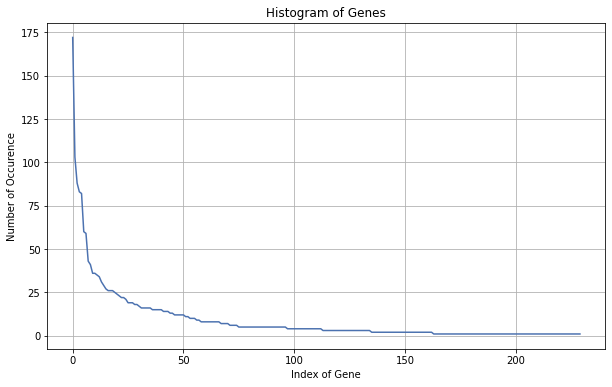

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(genes_hist)
plt.title(label='Histogram of Genes')
plt.xlabel(xlabel='Index of Gene')
plt.ylabel(ylabel='Number of Occurence')
plt.grid()
plt.show()

In [54]:
genes_hist = genes_hist / genes_sum
genes_cumm_freq = np.cumsum(a=genes_hist)

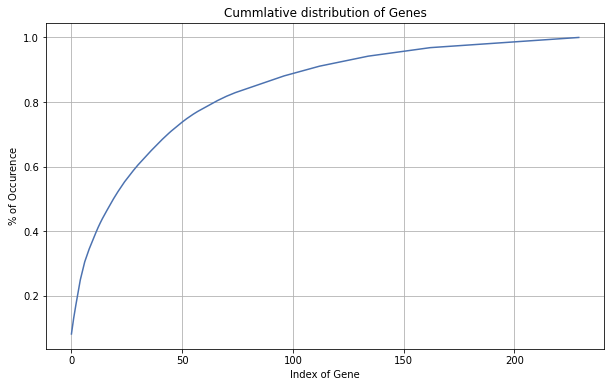

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(genes_cumm_freq)
plt.title(label='Cummlative distribution of Genes')
plt.xlabel(xlabel='Index of Gene')
plt.ylabel(ylabel='$\%$ of Occurence')
plt.grid()
plt.show()

3. How to featurize the Gene feature?
    - One-Hot Encoding - better for logistice regression model
    - Response Coding - better for RandomForests model

Response Coding on Gene

In [56]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Gene'], t_col='Class')
train_gene_rc = rc.perform_response_coding(df='train', laplace=True)
cv_gene_rc = rc.perform_response_coding(df='cv', laplace=True)
test_gene_rc = rc.perform_response_coding(df='test', laplace=True)

In [57]:
print(train_gene_rc.shape)
print(cv_gene_rc.shape)
print(test_gene_rc.shape)

(2124, 9)
(532, 9)
(665, 9)


One-Hot Encoding on Gene

In [58]:
genes_vect = CountVectorizer()
train_gene_oh = genes_vect.fit_transform(raw_documents=train_df['Gene'])
cv_gene_oh = genes_vect.transform(raw_documents=cv_df['Gene'])
test_gene_oh = genes_vect.transform(raw_documents=test_df['Gene'])

In [59]:
print(train_gene_oh.shape)
print(cv_gene_oh.shape)
print(test_gene_oh.shape)

(2124, 230)
(532, 230)
(665, 230)


In [60]:
print(genes_vect.get_feature_names_out()[:5])

['abl1' 'acvr1' 'ago2' 'akt1' 'akt2']


4. How good is this Gene feaure in predicting the Class label?
    - There are many ways to estimate how good a feature is, in predicting $y_i$.
    - One of the good methods is to build a proper ML model using just this feature.
    - In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict $y_i$.

Hyperparameter Tuning


alpha   logloss
0  0.00001  1.214769
1  0.00010  1.200919
2  0.00100  1.238127
3  0.01000  1.346686
4  0.10000  1.445541
5  1.00000  1.491908

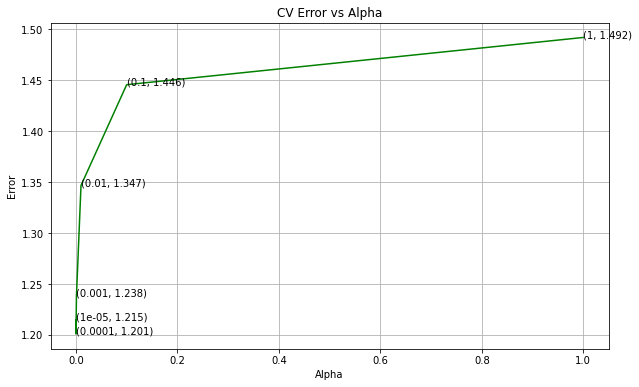

Train
Logloss (Train): 0.9938521485538796 for best alpha: 0.0001
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1.  1.  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


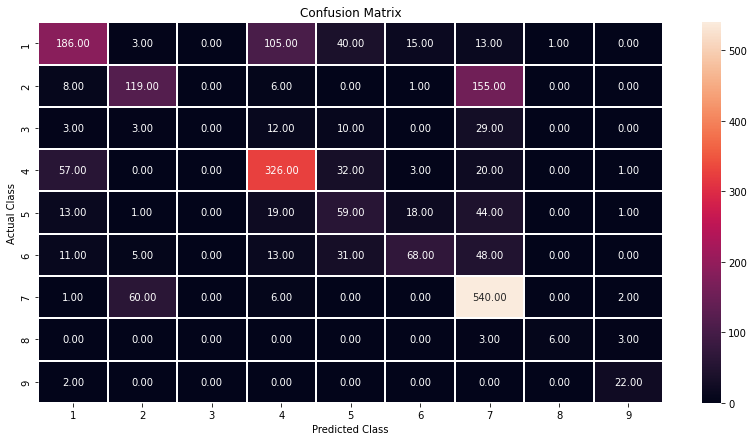

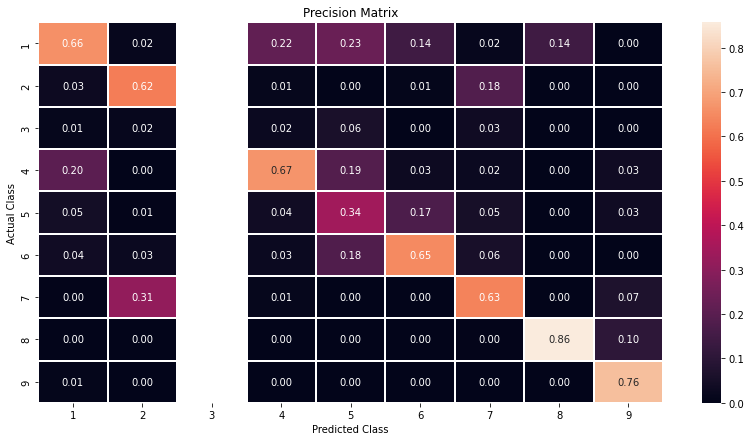

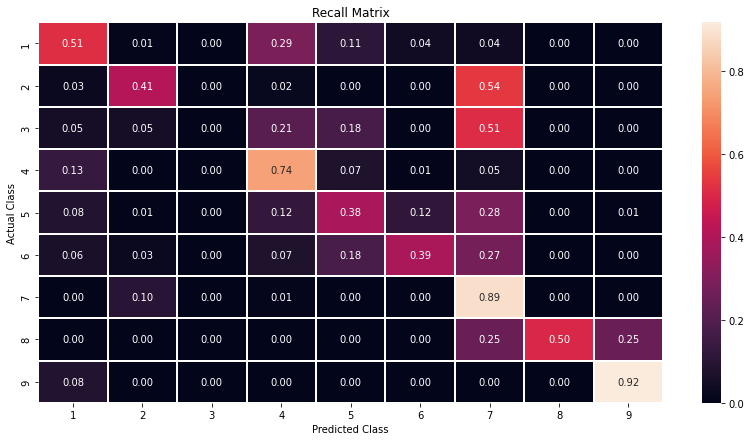

              precision    recall  f1-score   support

           1       0.66      0.51      0.58       363
           2       0.62      0.41      0.50       289
           3       0.00      0.00      0.00        57
           4       0.67      0.74      0.70       439
           5       0.34      0.38      0.36       155
           6       0.65      0.39      0.48       176
           7       0.63      0.89      0.74       609
           8       0.86      0.50      0.63        12
           9       0.76      0.92      0.83        24

    accuracy                           0.62      2124
   macro avg       0.58      0.53      0.54      2124
weighted avg       0.61      0.62      0.60      2124


Cross Validation
Logloss (CV): 1.2009189360327839 for best alpha: 0.0001
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


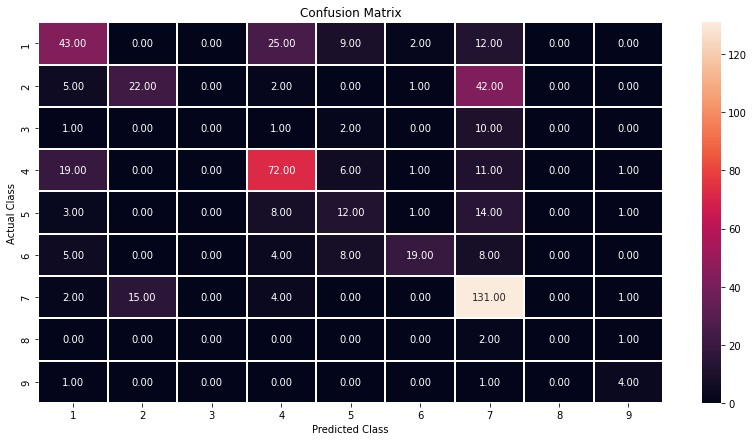

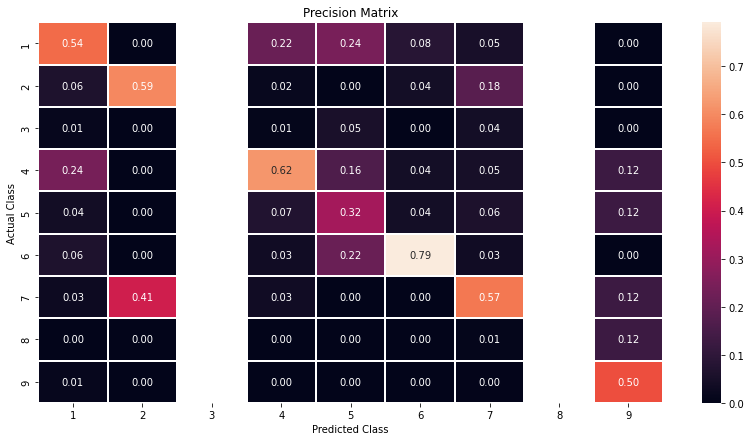

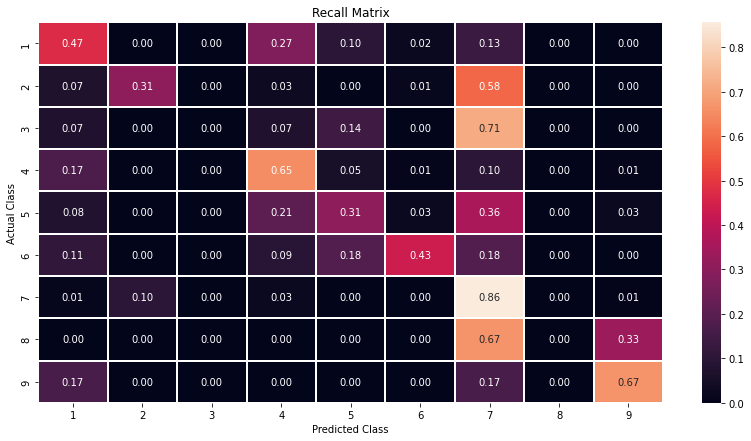

              precision    recall  f1-score   support

           1       0.54      0.47      0.51        91
           2       0.59      0.31      0.40        72
           3       0.00      0.00      0.00        14
           4       0.62      0.65      0.64       110
           5       0.32      0.31      0.32        39
           6       0.79      0.43      0.56        44
           7       0.57      0.86      0.68       153
           8       0.00      0.00      0.00         3
           9       0.50      0.67      0.57         6

    accuracy                           0.57       532
   macro avg       0.44      0.41      0.41       532
weighted avg       0.56      0.57      0.54       532


Test
Logloss (Test): 1.1671991563216293 for best alpha: 0.0001
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1.  1.  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


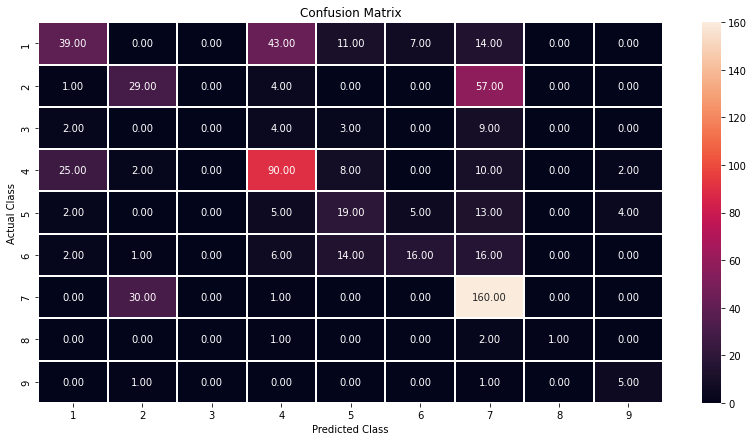

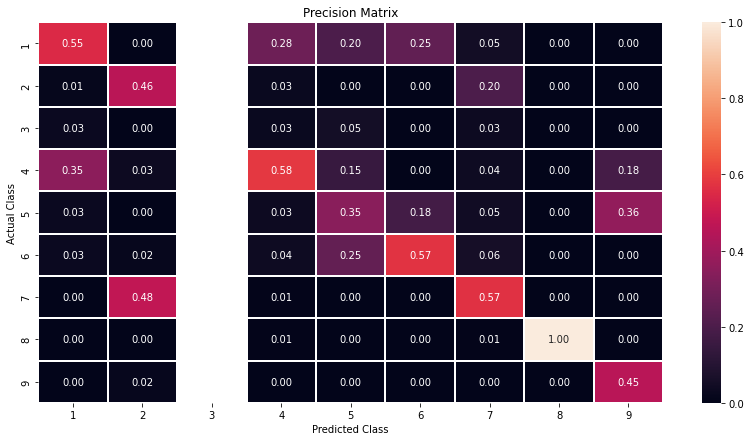

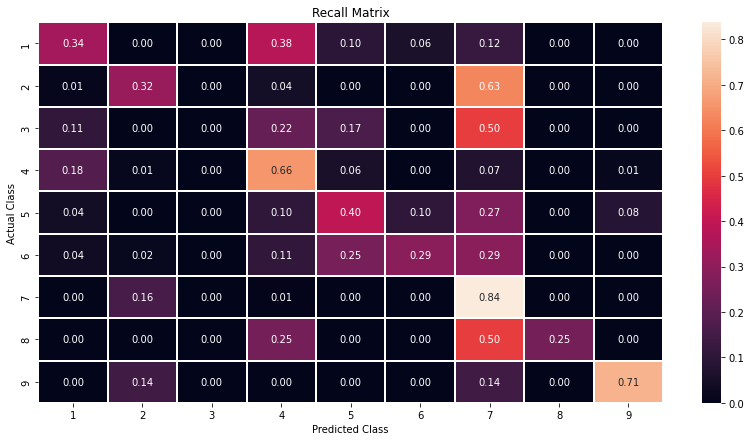

              precision    recall  f1-score   support

           1       0.55      0.34      0.42       114
           2       0.46      0.32      0.38        91
           3       0.00      0.00      0.00        18
           4       0.58      0.66      0.62       137
           5       0.35      0.40      0.37        48
           6       0.57      0.29      0.39        55
           7       0.57      0.84      0.68       191
           8       1.00      0.25      0.40         4
           9       0.45      0.71      0.56         7

    accuracy                           0.54       665
   macro avg       0.50      0.42      0.42       665
weighted avg       0.52      0.54      0.51       665



In [61]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(X_train=train_gene_oh,
            X_cv=cv_gene_oh,
            X_test=test_gene_oh,
            y_train=y_train,
            y_cv=y_cv,
            y_test=y_test,
            alpha_params=alpha_params,
            loss='log_loss')

5. Is Gene feature stable across the data sets (Train, Test, and Validation)?
    - Yes, it is. Otherwise, the CV and Test errors would be significantly more than Train error.

In [62]:
cv_coverage = cv_df[cv_df['Gene'].isin(train_df['Gene'])]
cv_pc = round((cv_coverage.shape[0] / cv_df.shape[0]) * 100, 2)
print("CV coverage: {} / {}, percentage of coverage: {}%.".format(cv_coverage.shape[0], cv_df.shape[0], cv_pc))

test_coverage = test_df[test_df['Gene'].isin(train_df['Gene'])]
test_pc = round((test_coverage.shape[0] / test_df.shape[0]) * 100, 2)
print("Test coverage: {} / {}, percentage of coverage: {}%.".format(test_coverage.shape[0], test_df.shape[0], test_pc))

CV coverage: 515 / 532, percentage of coverage: 96.8%.
Test coverage: 640 / 665, percentage of coverage: 96.24%.


Univariate Analysis on Variation Feature

Questions

1. Variation, what type of feature is it?
2. How many categories are there? How are they distributed?
3. How to featurize the Variation feature?
4. How good is this Variation feaure in predicting the Class label?
5. Is Variation feature stable across the data sets (Train, Test, and Validation)?

1. Variation, what type of feature is it?
    - Variation feature is categorical feature.

2. How many categories are there? How are they distributed?

In [63]:
unique_variation = train_df['Variation'].value_counts().to_frame()
print(unique_variation.shape)
display(unique_variation.head(n=10))

(1925, 1)


Variation
Truncating_Mutations         52
Deletion                     50
Amplification                50
Fusions                      19
Overexpression                4
Q61L                          3
Q61H                          3
G12V                          3
E17K                          3
F384L                         2

In [64]:
variation_sum = np.sum(a=unique_variation['Variation'])
variation_hist = unique_variation['Variation'].values

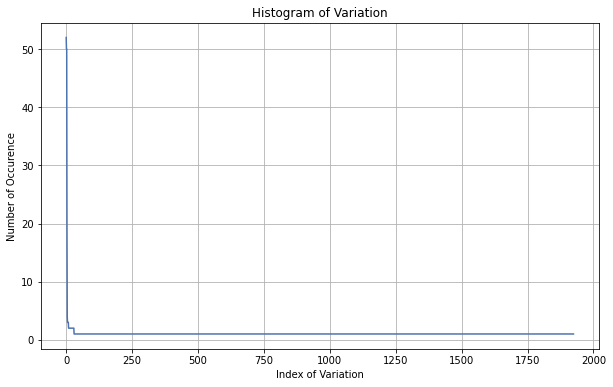

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(variation_hist)
plt.title(label='Histogram of Variation')
plt.xlabel(xlabel='Index of Variation')
plt.ylabel(ylabel='Number of Occurence')
plt.grid()
plt.show()

In [66]:
variation_hist = variation_hist / variation_hist
variation_cumm_freq = np.cumsum(a=variation_hist)

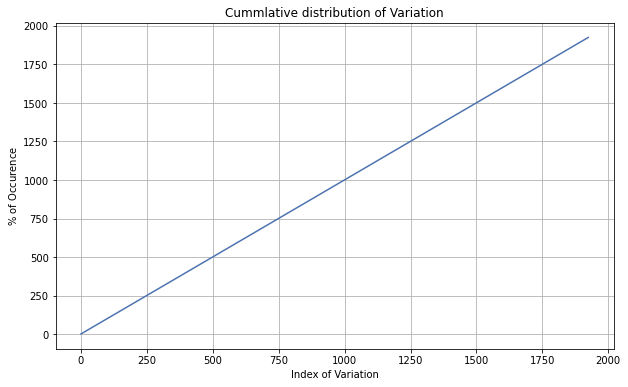

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(variation_cumm_freq)
plt.title(label='Cummlative distribution of Variation')
plt.xlabel(xlabel='Index of Variation')
plt.ylabel(ylabel='$\%$ of Occurence')
plt.grid()
plt.show()

3. How to featurize the Variation feature?
    - One-Hot Encoding - better for logistice regression model
    - Response Coding - better for RandomForests model

Response Coding on Variation

In [68]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Variation'], t_col='Class')
train_variation_rc = rc.perform_response_coding(df='train', laplace=True)
cv_variation_rc = rc.perform_response_coding(df='cv', laplace=True)
test_variation_rc = rc.perform_response_coding(df='test', laplace=True)

In [69]:
print(train_variation_rc.shape)
print(cv_variation_rc.shape)
print(test_variation_rc.shape)

(2124, 9)
(532, 9)
(665, 9)


One-Hot Encoding on Variation

In [70]:
variation_vect = CountVectorizer()
train_variation_oh = variation_vect.fit_transform(raw_documents=train_df['Variation'])
cv_variation_oh = variation_vect.transform(raw_documents=cv_df['Variation'])
test_variation_oh = variation_vect.transform(raw_documents=test_df['Variation'])

In [71]:
print(train_variation_oh.shape)
print(cv_variation_oh.shape)
print(test_variation_oh.shape)

(2124, 1954)
(532, 1954)
(665, 1954)


In [72]:
print(variation_vect.get_feature_names_out()[:5])

['17' '1_2009trunc' '1_fusion' '256_286trunc' '385_418del']


4. How good is this Variation feaure in predicting the Class label?
    - There are many ways to estimate how good a feature is, in predicting $y_i$.
    - One of the good methods is to build a proper ML model using just this feature.
    - In this case, we will build a logistic regression model using only Variation feature (one hot encoded) to predict $y_i$.

Hyperparameter Tuning


alpha   logloss
0  0.00001  1.711377
1  0.00010  1.705283
2  0.00100  1.700693
3  0.01000  1.702969
4  0.10000  1.715779
5  1.00000  1.717022

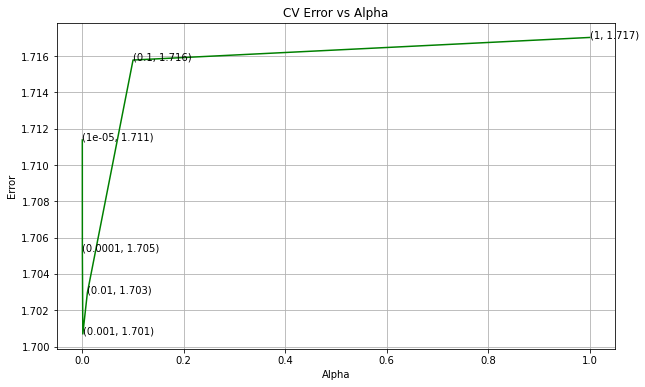

Train
Logloss (Train): 1.0621415097585183 for best alpha: 0.001
Column sum of precision matrix: [ 1.  1.  1.  1.  1.  1.  1.  1. nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


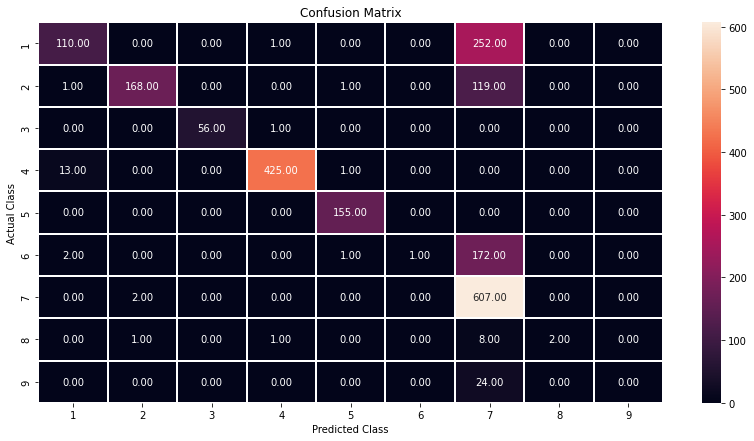

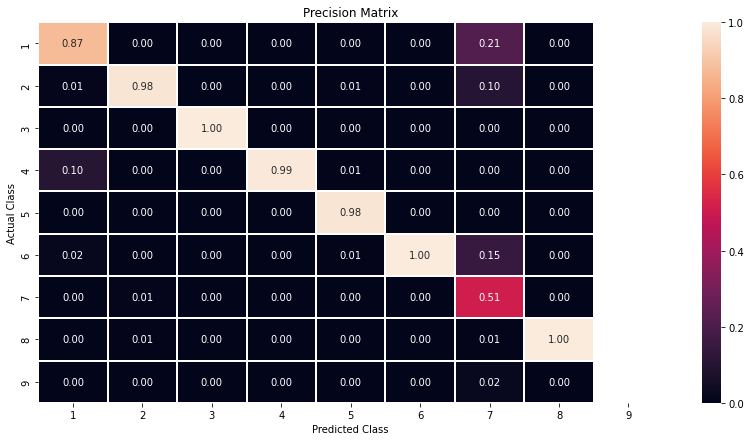

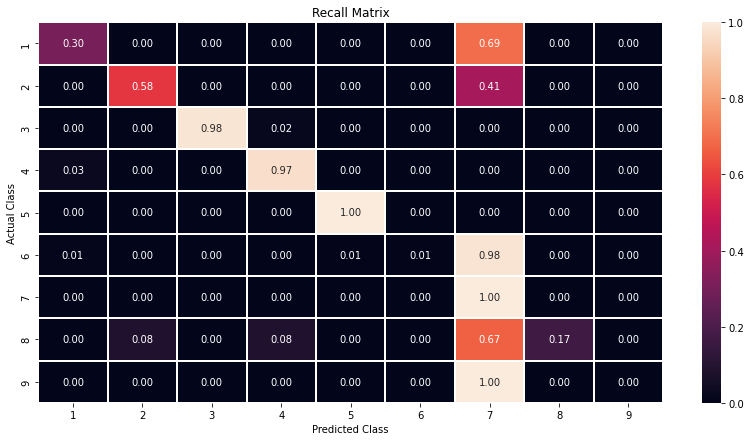

              precision    recall  f1-score   support

           1       0.87      0.30      0.45       363
           2       0.98      0.58      0.73       289
           3       1.00      0.98      0.99        57
           4       0.99      0.97      0.98       439
           5       0.98      1.00      0.99       155
           6       1.00      0.01      0.01       176
           7       0.51      1.00      0.68       609
           8       1.00      0.17      0.29        12
           9       0.00      0.00      0.00        24

    accuracy                           0.72      2124
   macro avg       0.82      0.56      0.57      2124
weighted avg       0.82      0.72      0.67      2124


Cross Validation
Logloss (CV): 1.7006928501480831 for best alpha: 0.001
Column sum of precision matrix: [ 1.  1. nan  1.  1. nan  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


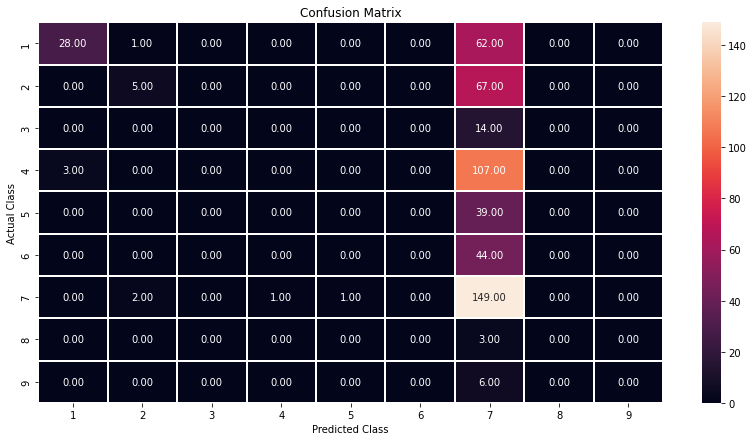

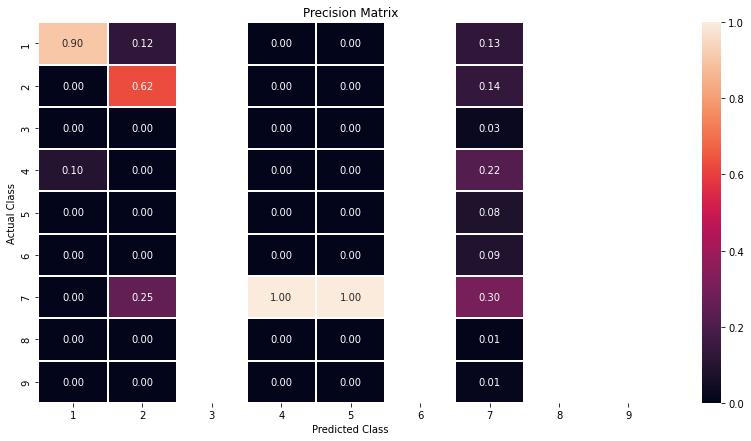

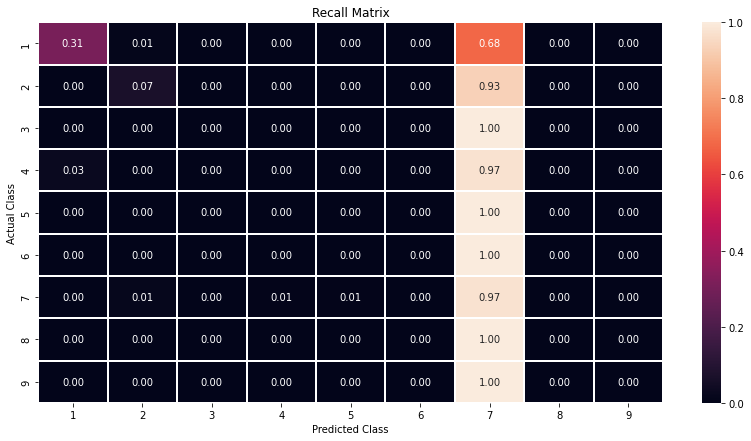

              precision    recall  f1-score   support

           1       0.90      0.31      0.46        91
           2       0.62      0.07      0.12        72
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00       110
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00        44
           7       0.30      0.97      0.46       153
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6

    accuracy                           0.34       532
   macro avg       0.20      0.15      0.12       532
weighted avg       0.33      0.34      0.23       532


Test
Logloss (Test): 1.693860930255968 for best alpha: 0.001
Column sum of precision matrix: [ 1.  1.  1.  1. nan nan  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


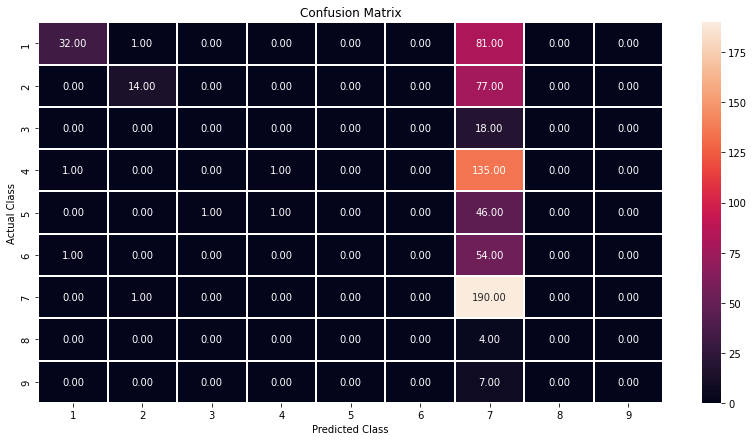

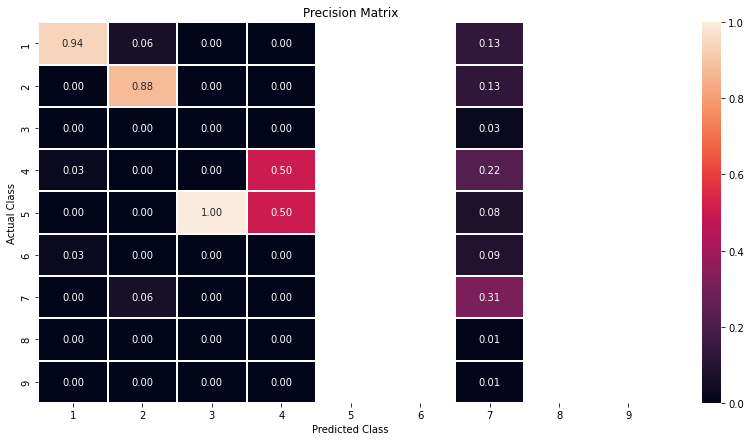

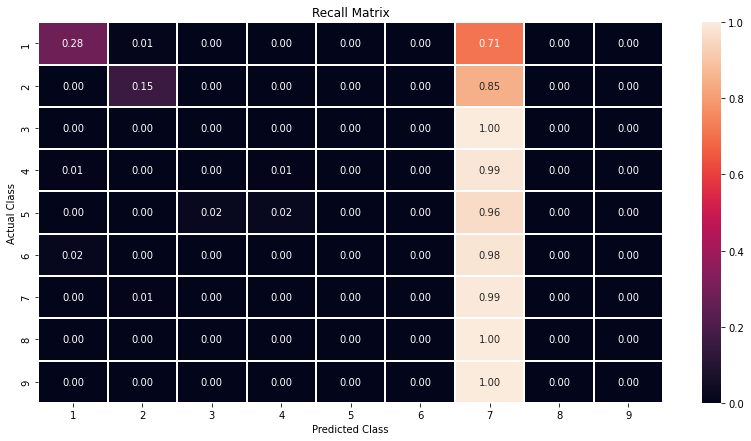

              precision    recall  f1-score   support

           1       0.94      0.28      0.43       114
           2       0.88      0.15      0.26        91
           3       0.00      0.00      0.00        18
           4       0.50      0.01      0.01       137
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        55
           7       0.31      0.99      0.47       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.36       665
   macro avg       0.29      0.16      0.13       665
weighted avg       0.47      0.36      0.25       665



In [73]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(X_train=train_variation_oh,
            X_cv=cv_variation_oh,
            X_test=test_variation_oh,
            y_train=y_train,
            y_cv=y_cv,
            y_test=y_test,
            alpha_params=alpha_params,
            loss='log_loss')

5. Is Variation feature stable across the data sets (Train, Test, and Validation)?
    - Not sure, but the CV and Test errors are somewhat matching with Train error.

In [74]:
cv_coverage = cv_df[cv_df['Variation'].isin(train_df['Variation'])]
cv_pc = round((cv_coverage.shape[0] / cv_df.shape[0]) * 100, 2)
print("CV coverage: {} / {}, percentage of coverage: {}%.".format(cv_coverage.shape[0], cv_df.shape[0], cv_pc))

test_coverage = test_df[test_df['Variation'].isin(train_df['Variation'])]
test_pc = round((test_coverage.shape[0] / test_df.shape[0]) * 100, 2)
print("Test coverage: {} / {}, percentage of coverage: {}%.".format(test_coverage.shape[0], test_df.shape[0], test_pc))

CV coverage: 58 / 532, percentage of coverage: 10.9%.
Test coverage: 64 / 665, percentage of coverage: 9.62%.


Univariate Analysis on TEXT Feature

Questions

1. TEXT, what type of feature is it?
2. How many categories are there? How are they distributed?
3. How to featurize the TEXT feature?
4. How good is this TEXT feaure in predicting the TEXT label?
5. Is TEXT feature stable across the data sets (Train, Test, and Validation)?

BoW on TEXT

In [75]:
text_vect = CountVectorizer(min_df=3)
train_text_oh = text_vect.fit_transform(raw_documents=train_df['TEXT'])
# Feature names
train_text_features = text_vect.get_feature_names_out()
# Feature count sum
# Take the sum of all the rows in each column and flatten it.
train_text_features_sum = train_text_oh.sum(axis=0).A1
print("Total number of unique words in train data: {}".format(len(train_text_features)))

Total number of unique words in train data: 52430


Response Coding for TEXT

In [76]:
class ResponseCodingText(object):
    """
    This class is responsible for response coding for text features.
    """
    
    def __init__(self, classes, alpha, factor, label):
        self.classes = classes
        self.k = len(self.classes)
        self.alpha = alpha
        self.factor = factor
        self.label = label
    
    def extract_dict_paddles(self, df, col):
        """
        This method extracts the histogram for the col in df.
        """
        total_paddle = defaultdict(int)
        text_vals = df[col].to_list()
        for t_val in text_vals:
            for word in t_val.split():
                total_paddle[word] += 1
        return total_paddle
    
    def extract_paddles_by_class(self, df, col):
        """
        This method extracts the histogram by class for the col in df.
        """
        class_paddles = list()
        for cls_ in tqdm(self.classes):
            cls_frame = df[df[self.label] == cls_]
            c_paddle = self.extract_dict_paddles(df=df, col=col)
            class_paddles.append(c_paddle)
        total_paddle = self.extract_dict_paddles(df=df, col=col)
        return class_paddles, total_paddle
    
    def get_text_response_coding(self, df, col, class_paddles, total_paddle):
        """
        This method gets the response coding.
        """
        text_val = df[col].to_list()
        text_splits = list(map(str.split, text_val))
        text_rc = np.zeros(shape=(df.shape[0], self.k))
        for i in tqdm(range(self.k)):
            row_i = 0
            for t_split in text_splits:
                sum_prob = 0
                for word in t_split:
                    n_val = class_paddles[i].get(word, 0) + (self.alpha * self.factor)
                    d_val = total_paddle.get(word, 0) + (self.alpha * self.factor * self.k)
                    sum_prob += math.log(n_val / d_val)
                text_rc[row_i][i] = math.exp(sum_prob / len(t_split))
                row_i += 1
        return text_rc

The main reason for that divide operation in line 51 in above cell is for normalization so if we do it by some constant we may give some high probabilities to long sentences and very low probabilities to small sentences. So we used the length of that sentence to normalize.

In [77]:
rc_text = ResponseCodingText(classes=labels, alpha=1, factor=10, label='Class')

In [78]:
class_paddles, total_paddle = rc_text.extract_paddles_by_class(df=train_df, col='TEXT')

100%|█████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]


In [79]:
train_text_rc = rc_text.get_text_response_coding(df=train_df,
                                                 col='TEXT',
                                                 class_paddles=class_paddles,
                                                 total_paddle=total_paddle)

100%|█████████████████████████████████████████████████████████████████████| 9/9 [01:06<00:00,  7.37s/it]


In [80]:
cv_text_rc = rc_text.get_text_response_coding(df=cv_df,
                                              col='TEXT',
                                              class_paddles=class_paddles,
                                              total_paddle=total_paddle)

100%|█████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.78s/it]


In [81]:
test_text_rc = rc_text.get_text_response_coding(df=test_df,
                                                col='TEXT',
                                                class_paddles=class_paddles,
                                                total_paddle=total_paddle)

100%|█████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.27s/it]


In [82]:
print(train_text_rc.shape)
print(cv_text_rc.shape)
print(test_text_rc.shape)

(2124, 9)
(532, 9)
(665, 9)


One-Hot Encoding on TEXT

In [83]:
train_text_oh = normalize(X=train_text_oh, axis=0)
cv_text_oh = text_vect.transform(raw_documents=cv_df['TEXT'])
cv_text_oh = normalize(X=cv_text_oh)
test_text_oh = text_vect.transform(raw_documents=test_df['TEXT'])
test_text_oh = normalize(X=test_text_oh)

In [84]:
print(train_text_oh.shape)
print(cv_text_oh.shape)
print(test_text_oh.shape)

(2124, 52430)
(532, 52430)
(665, 52430)


In [85]:
# Feature dictionary
text_feature_dictionary = dict(zip(train_text_features, train_text_features_sum))

In [86]:
sorted_text_feature_dictionary = dict(sorted(text_feature_dictionary.items(), key=lambda x: x[1], reverse=True))
sorted_text_occurrence = np.array(list(sorted_text_feature_dictionary.values()))
print(sorted_text_occurrence[:5])

[148865 118721  79944  67838  67747]


In [87]:
# Number of words for a given frequency
# print(Counter(sorted_text_occurrence))

4. How good is this TEXT feaure in predicting the TEXT label?
- There are many ways to estimate how good a feature is, in predicting $y_i$.
- One of the good methods is to build a proper ML model using just this feature.
- In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict $y_i$.

Hyperparameter Tuning


alpha   logloss
0  0.00001  1.774133
1  0.00010  1.696674
2  0.00100  1.677755
3  0.01000  1.709440
4  0.10000  1.776134
5  1.00000  1.814537

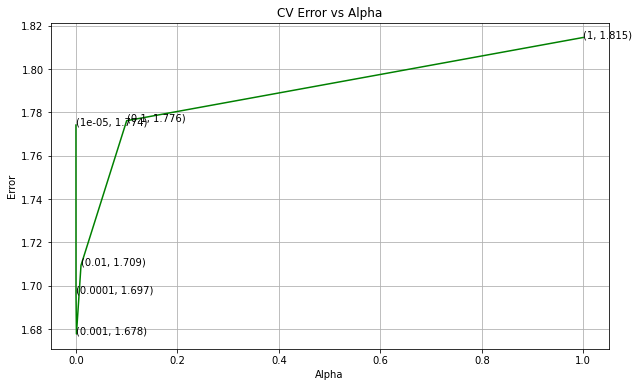

Train
Logloss (Train): 0.658958591645827 for best alpha: 0.001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


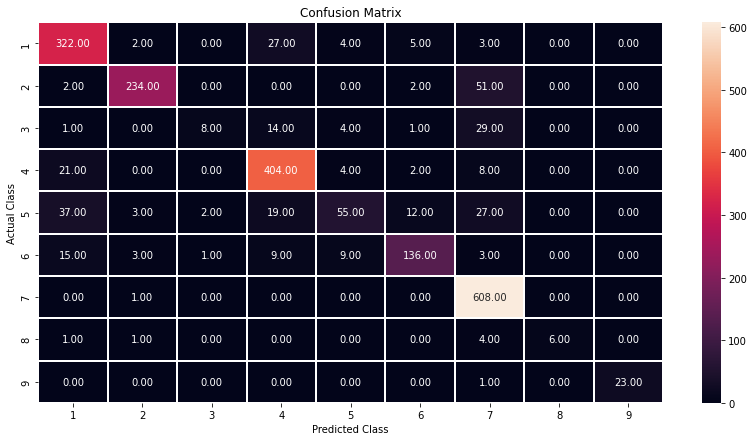

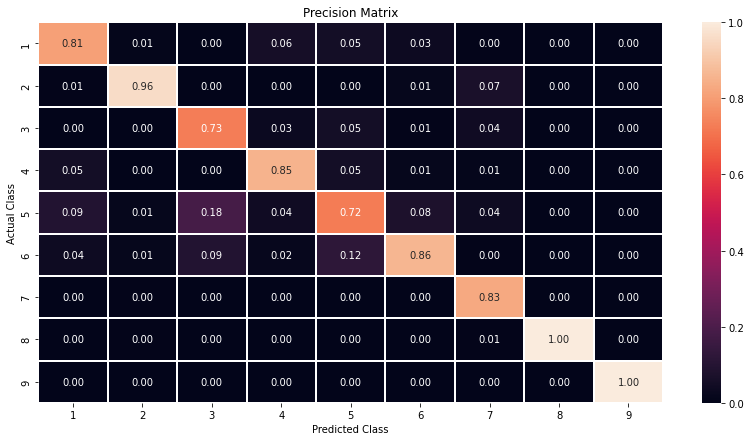

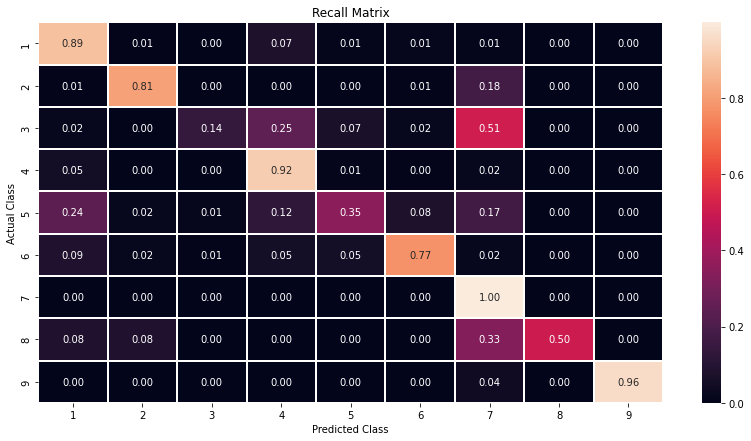

              precision    recall  f1-score   support

           1       0.81      0.89      0.85       363
           2       0.96      0.81      0.88       289
           3       0.73      0.14      0.24        57
           4       0.85      0.92      0.89       439
           5       0.72      0.35      0.48       155
           6       0.86      0.77      0.81       176
           7       0.83      1.00      0.91       609
           8       1.00      0.50      0.67        12
           9       1.00      0.96      0.98        24

    accuracy                           0.85      2124
   macro avg       0.86      0.70      0.74      2124
weighted avg       0.84      0.85      0.83      2124


Cross Validation
Logloss (CV): 1.677754615175014 for best alpha: 0.001
Column sum of precision matrix: [ 1. nan nan  1. nan nan  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


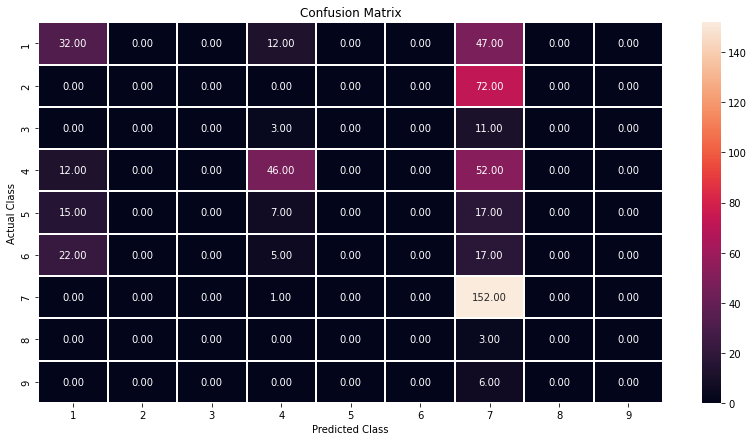

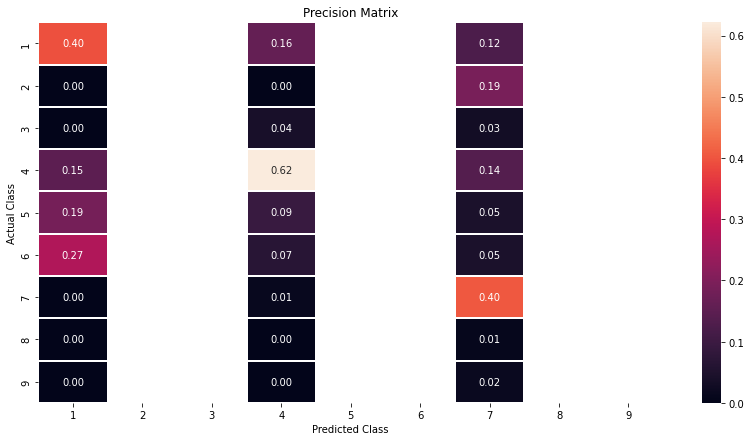

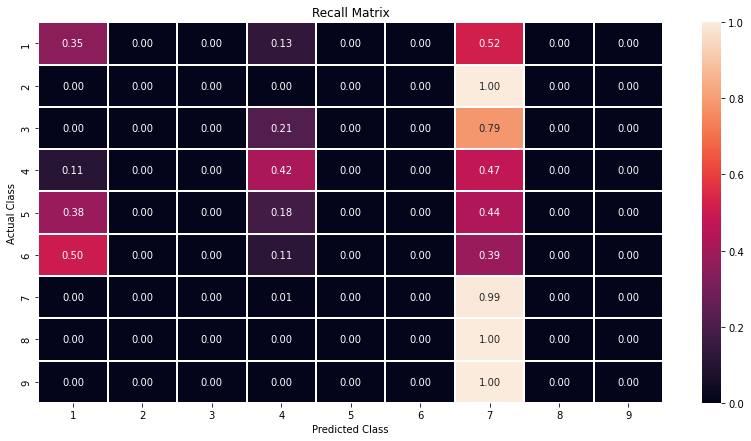

              precision    recall  f1-score   support

           1       0.40      0.35      0.37        91
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        14
           4       0.62      0.42      0.50       110
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00        44
           7       0.40      0.99      0.57       153
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6

    accuracy                           0.43       532
   macro avg       0.16      0.20      0.16       532
weighted avg       0.31      0.43      0.33       532


Test
Logloss (Test): 1.6707497108701332 for best alpha: 0.001
Column sum of precision matrix: [ 1. nan nan  1. nan nan  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


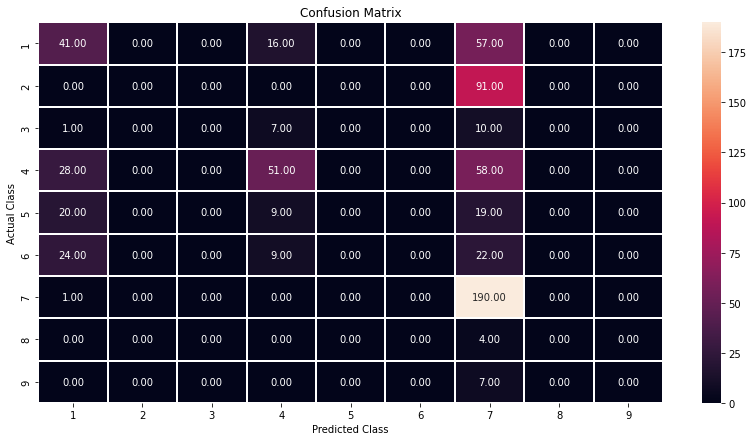

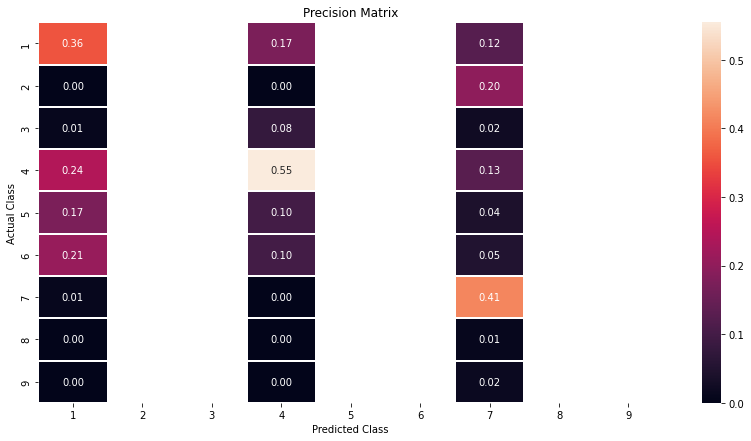

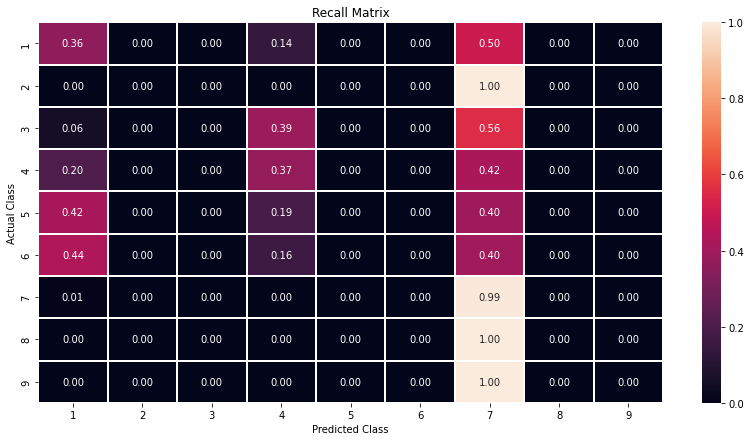

              precision    recall  f1-score   support

           1       0.36      0.36      0.36       114
           2       0.00      0.00      0.00        91
           3       0.00      0.00      0.00        18
           4       0.55      0.37      0.45       137
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        55
           7       0.41      0.99      0.59       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.42       665
   macro avg       0.15      0.19      0.15       665
weighted avg       0.29      0.42      0.32       665



In [88]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(X_train=train_text_oh,
            X_cv=cv_text_oh,
            X_test=test_text_oh,
            y_train=y_train,
            y_cv=y_cv,
            y_test=y_test,
            alpha_params=alpha_params,
            loss='log_loss')

5. Is TEXT feature stable across the data sets (Train, Test, and Validation)?
    - Yes, it seems.

In [89]:
def get_text_intersection(df, col, train_text_features):
    """
    This function gets the % of words present in train features for `test_df` and `cv_df`.
    """
    text_vect = CountVectorizer(min_df=3)
    text_oh = text_vect.fit_transform(raw_documents=df[col])
    text_features = text_vect.get_feature_names_out()
    text_features_sum = text_oh.sum(axis=0).A1
    text_feature_dictionary = dict(zip(text_features, text_features_sum))
    
    text_set_features = set(text_features)
    train_set_features = set(train_text_features)
    
    len1 = len(text_set_features)
    len2 = len(train_set_features & text_set_features)
    return len1, len2

In [90]:
len1, len2 = get_text_intersection(df=cv_df, col='TEXT', train_text_features=train_text_features)
print("The {}% of words of cross validation data appeared in train data.".format(np.round((len2 / len1) * 100, 2)))

len1, len2 = get_text_intersection(df=test_df, col='TEXT', train_text_features=train_text_features)
print("The {}% of words of test data appeared in train data.".format(np.round((len2 / len1) * 100, 2)))

The 97.82% of words of cross validation data appeared in train data.
The 96.34% of words of test data appeared in train data.


Machine Learning Model

In [91]:
def predict_and_plot_confusion_matrix(clf, X_train, X_test, y_train, y_test, show_plot=False):
    """
    This function predicts and plots the confusion matrix.
    """
    clf.fit(X=X_train, y=y_train)
    
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    y_pred_proba = sif_clf.predict_proba(X=X_test)
    lloss = log_loss(y_true=y_test, y_pred=y_pred_proba)
    print("Logloss: {}".format(lloss))
    
    y_pred = sig_clf.predict(X=X_test)
    misclassified = np.count_nonzero(a=(y_pred - y_test) / (y_test.shape[0]))
    print("Number of mis-classified points: {}".format())
    
    if show_plot:
        plot_confusion_matrix(y_true=y_test, y_pred=y_pred)
    return y_pred

In [92]:
def report_log_loss(clf, X_train, X_test, y_train, y_test):
    """
    This method returns log_loss.
    """
    clf.fit(X=X_train, y=y_train)
    
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    y_pred_proba = sig_clf.predict_proba(X=X_test)
    lloss = log_loss(y_true=y_test, y_pred=y_pred_proba)
    return lloss

In [93]:
def fetch_important_features(indices, gene, variation, text, no_features):
    """
    This function will be used just for naive bayes.
    For the given indices, we will print the name of the features.
    We will also check whether the feature is present in the test point or not.
    """
    gene_vect = CountVectorizer()
    variation_vect = CountVectorizer()
    text_vect = CountVectorizer(min_df=3)

    gene_vect.fit(raw_documents=train_df['Gene'])
    variation_vect.fit(raw_documents=train_df['Variation'])
    text_vect.fit(raw_documents=train_df['TEXT'])
    
    gene_features = gene_vect.get_feature_names_out()
    variation_features = variation_vect.get_feature_names_out()
    text_features = text_vect.get_feature_names_out()

    fea1_len = len(gene_features)
    fea2_len = len(variation_features)
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < fea1_len:
            word = gene_features[v]
            y_n = True if word == gene.lower() else False
            if y_n:
                word_present += 1
                print("{} --> Gene feature [{}] present in test data point: {}".format(i, word, y_n))
        elif v < fea1_len + fea2_len:
            word = variation_features[v - fea1_len]
            y_n = True if word == variation.lower() else False
            if y_n:
                word_present += 1
                print("{} --> Variation feature [{}] present in test data point: {}".format(i, word, y_n))
        else:
            word = text_features[v - (fea1_len + fea2_len)]
            y_n = True if word in text.split() else False
            if y_n:
                word_present += 1
                print("{} --> Text feature [{}] present in test data: {}".format(i, word, y_n))
    
    print("Out of the top {} features {} feature(s) are present in the query point.".format(no_features, word_present))

Stacking one hot encoded data.

In [94]:
X_train_oh = sparse.hstack(blocks=[train_gene_oh, train_variation_oh, train_text_oh]).tocsr()
X_cv_oh = sparse.hstack(blocks=[cv_gene_oh, cv_variation_oh, cv_text_oh]).tocsr()
X_test_oh = sparse.hstack(blocks=[test_gene_oh, test_variation_oh, test_text_oh]).tocsr()

In [95]:
print(X_train_oh.shape)
print(X_cv_oh.shape)
print(X_test_oh.shape)

(2124, 54614)
(532, 54614)
(665, 54614)


Stacking response coded data.

In [96]:
X_train_rc = np.hstack(tup=(train_gene_rc, train_variation_rc, train_text_rc))
X_cv_rc = np.hstack(tup=(cv_gene_rc, cv_variation_rc, cv_text_rc))
X_test_rc = np.hstack(tup=(test_gene_rc, test_variation_rc, test_text_rc))

In [97]:
print(X_train_rc.shape)
print(X_cv_rc.shape)
print(X_test_rc.shape)

(2124, 27)
(532, 27)
(665, 27)


Model Development - Multinomial Naive Bayes and K-NN Classifier

In [98]:
def build_classifier_model(X_train,
                           X_cv,
                           X_test,
                           y_train,
                           y_cv,
                           y_test,
                           model_type,
                           hparams,
                           logify=False):
    """
    This function builds the classifier.
    """
    log_error_list = list()
    loss_df = pd.DataFrame()
    
    for i in hparams:
        if (model_type == 'multinb'):
            clf = MultinomialNB(alpha=i)
        elif (model_type == 'knn'):
            clf = KNeighborsClassifier(n_neighbors=i)
        
        clf.fit(X=X_train, y=y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        sig_clf_probs = sig_clf.predict_proba(X=X_cv)
        lloss = log_loss(y_true=y_cv, y_pred=sig_clf_probs, eps=1e-15)
        log_error_list.append(lloss)
    
    print("Hyperparameter Tuning")
    loss_df['alpha'] = hparams
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    hparams_logs = np.log10(hparams) if logify else hparams
    
    plt.figure(figsize=(10, 6))
    plt.plot(hparams_logs, log_error_list, c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(text=(hparams[i], str(txt)), xy=(hparams_logs[i], log_error_list[i]))
    plt.xticks(hparams_logs)
    plt.title(label='CV Error vs Alpha')
    plt.xlabel("Parameters")
    plt.ylabel('Errror Measure')
    plt.grid()
    plt.show()
    
    best_param = hparams[np.argmin(log_error_list)]
    if (model_type == 'multinb'):
        clf = MultinomialNB(alpha=best_param)
    elif (model_type == 'knn'):
        clf = KNeighborsClassifier(n_neighbors=best_param)
    
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best param: {}".format(train_loss, best_param))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best param: {}".format(cv_loss, best_param))
    miss_cv = np.count_nonzero(a=(cv_cm_pred - y_cv)) / (y_cv.shape[0])
    print("Number of missclassified points in cross validation data: {}".format(miss_cv))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best param: {}".format(test_loss, best_param))
    miss_test = np.count_nonzero(a=(test_cm_pred - y_test)) / (y_test.shape[0])
    print("Number of missclassified points in test data: {}".format(miss_test))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))
    
    if (model_type == 'multinb'):
        return clf, sig_clf
    return clf, sig_clf, best_param

In [99]:
def check_model_nb_perf(df, X_test, y_test, x_q_ind, n_feature_nums, clf, sig_clf, model='mnb'):
    """
    This function checks the model performance of Naive Bayes classifier.
    """
    point_data = X_test[x_q_ind]
    point_target = y_test[x_q_ind]
    
    predicted_class = sig_clf.predict(point_data)
    predicted_class_proba = np.round(sig_clf.predict_proba(point_data), 4)
    
    print("Predicted Class: {}".format(predicted_class))
    print("Predicted Class Probabilities: {}".format(predicted_class_proba))
    print("Actual Class: {}".format(point_target))
    
    if model == 'mnb':
        indices = np.argsort(-1 * abs(clf.feature_count_))[predicted_class - 1][:, :n_feature_nums]
    else:
        indices = np.argsort(-1 * abs(clf.coef_))[predicted_class - 1][:, :n_feature_nums]
    fetch_important_features(indices=indices[0],
                             text=df['TEXT'].iloc[x_q_ind],
                             gene=df['Gene'].iloc[x_q_ind],
                             variation=df['Variation'].iloc[x_q_ind],
                             no_features=n_feature_nums)

In [100]:
def check_model_knn_perf(X_test, y_test, y_train, x_q_ind, clf, sig_clf, best_param):
    """
    This function checks the model performance of K-NN Classifier.
    """
    point_data = X_test[x_q_ind].reshape(1, -1)
    point_target = y_test[x_q_ind]
    
    predicted_class = sig_clf.predict(point_data)
    
    print("Predicted Class: {}".format(predicted_class))
    print("Actual Class: {}".format(point_target))
    
    neighbors = clf.kneighbors(X=point_data, n_neighbors=best_param)
    print("The {} nearest neighbours of the test points belongs to classes {}.".format(best_param, y_train[neighbors[1][0]]))
    print("Fequency of nearest points: {}.".format(Counter(y_train[neighbors[1][0]])))

Multinomial Naive Bayes

Hyperparameter Tuning


alpha   logloss
0     0.00001  1.235052
1     0.00010  1.233612
2     0.00100  1.236191
3     0.10000  1.309270
4     1.00000  1.472233
5    10.00000  1.543886
6   100.00000  1.597174
7  1000.00000  1.550879

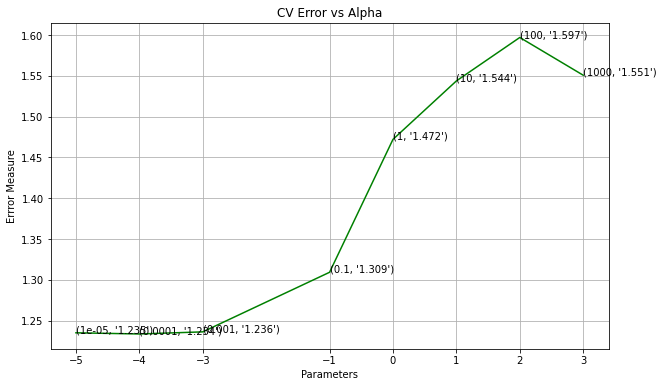

Train
Logloss (Train): 0.8032542857711606 for best param: 0.0001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


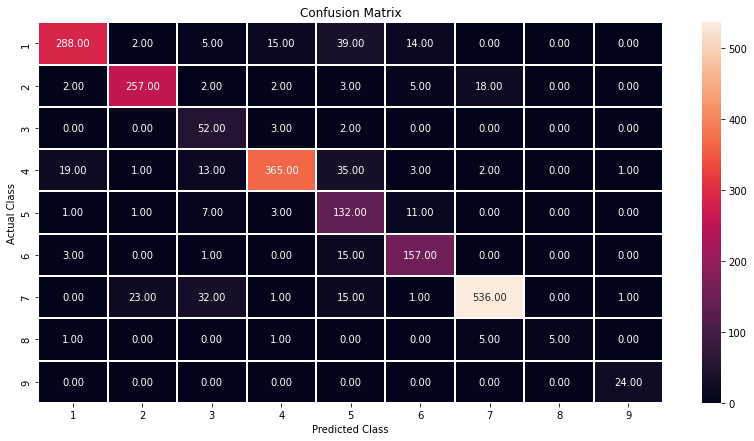

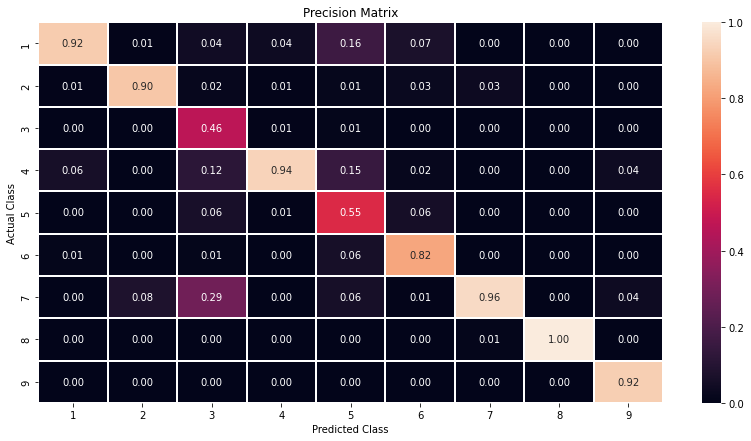

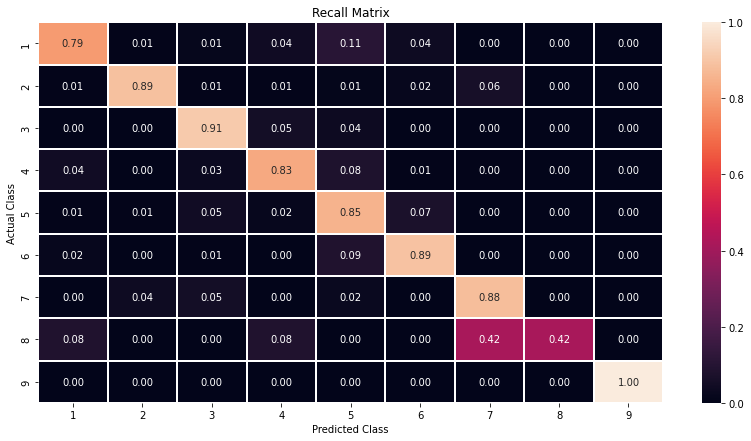

              precision    recall  f1-score   support

           1       0.92      0.79      0.85       363
           2       0.90      0.89      0.90       289
           3       0.46      0.91      0.62        57
           4       0.94      0.83      0.88       439
           5       0.55      0.85      0.67       155
           6       0.82      0.89      0.86       176
           7       0.96      0.88      0.92       609
           8       1.00      0.42      0.59        12
           9       0.92      1.00      0.96        24

    accuracy                           0.85      2124
   macro avg       0.83      0.83      0.80      2124
weighted avg       0.88      0.85      0.86      2124


Cross Validation
Logloss (CV): 1.2336122184170621 for best param: 0.0001
Number of missclassified points in cross validation data: 0.37218045112781956
Column sum of precision matrix: [ 1.  1.  1.  1.  1.  1.  1. nan  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


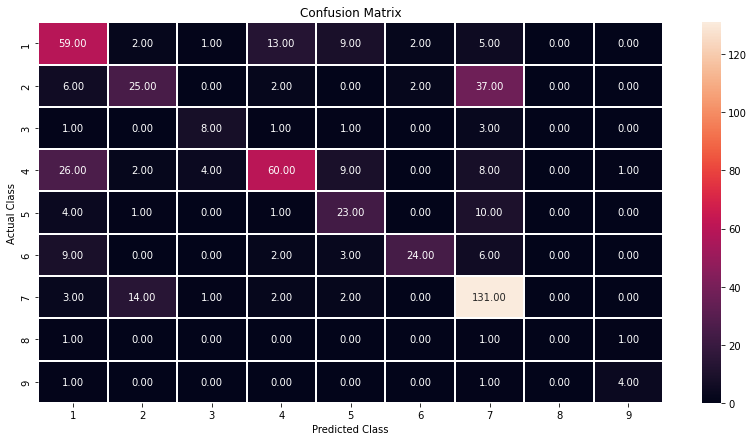

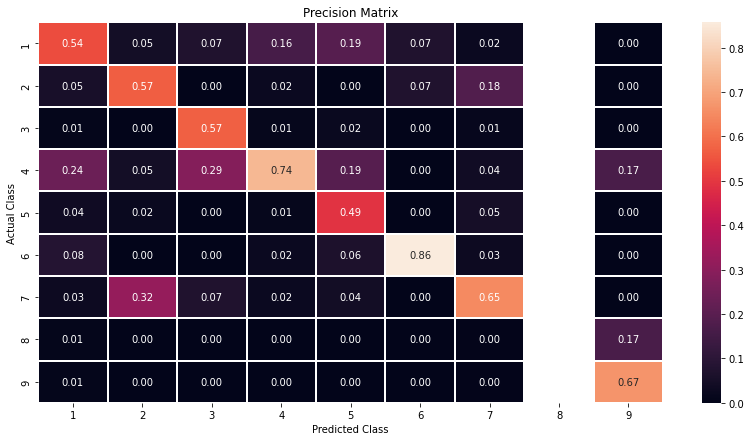

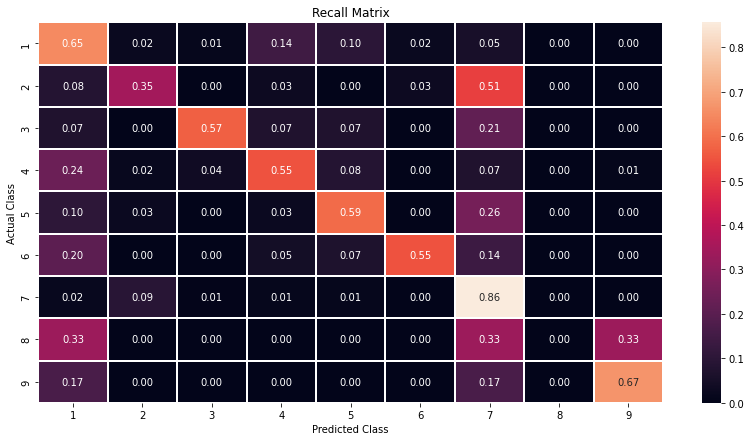

              precision    recall  f1-score   support

           1       0.54      0.65      0.59        91
           2       0.57      0.35      0.43        72
           3       0.57      0.57      0.57        14
           4       0.74      0.55      0.63       110
           5       0.49      0.59      0.53        39
           6       0.86      0.55      0.67        44
           7       0.65      0.86      0.74       153
           8       0.00      0.00      0.00         3
           9       0.67      0.67      0.67         6

    accuracy                           0.63       532
   macro avg       0.56      0.53      0.54       532
weighted avg       0.64      0.63      0.62       532


Test
Logloss (Test): 1.1736021123132374 for best param: 0.0001
Number of missclassified points in test data: 0.3533834586466165
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


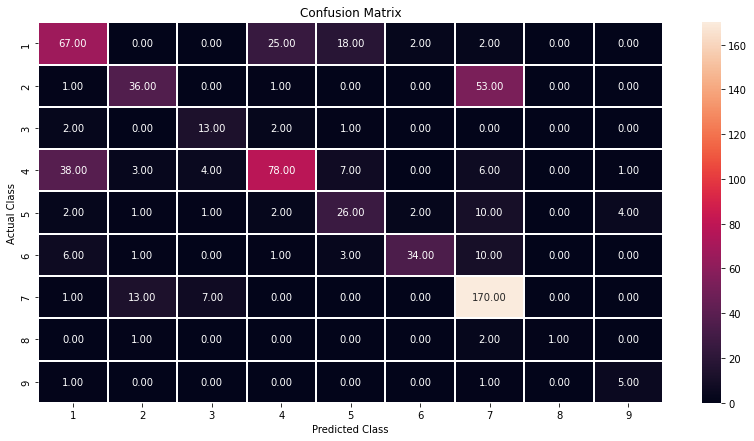

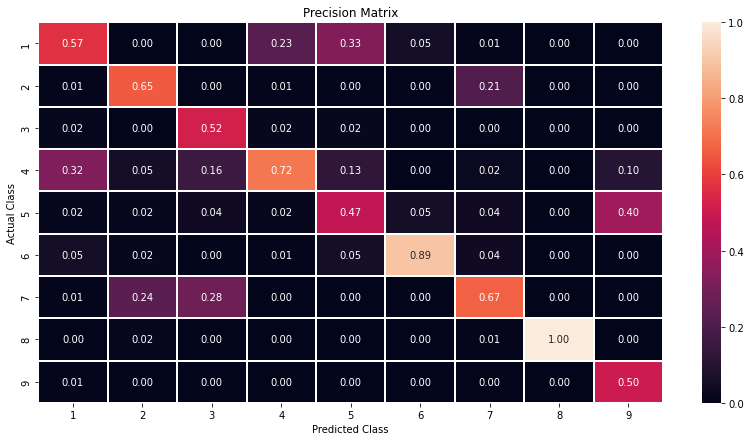

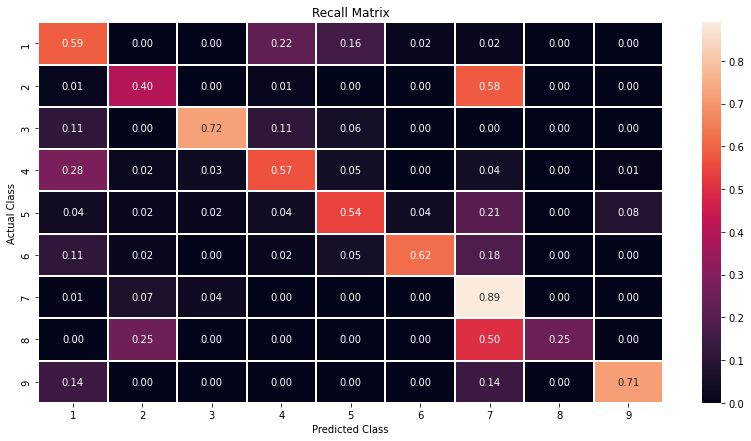

              precision    recall  f1-score   support

           1       0.57      0.59      0.58       114
           2       0.65      0.40      0.49        91
           3       0.52      0.72      0.60        18
           4       0.72      0.57      0.63       137
           5       0.47      0.54      0.50        48
           6       0.89      0.62      0.73        55
           7       0.67      0.89      0.76       191
           8       1.00      0.25      0.40         4
           9       0.50      0.71      0.59         7

    accuracy                           0.65       665
   macro avg       0.67      0.59      0.59       665
weighted avg       0.66      0.65      0.64       665



In [101]:
alpha_params = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]

multinb_clf, multinb_sig_clf = build_classifier_model(X_train=X_train_oh,
                                                      X_cv=X_cv_oh,
                                                      X_test=X_test_oh,
                                                      y_train=y_train,
                                                      y_cv=y_cv,
                                                      y_test=y_test,
                                                      model_type='multinb',
                                                      hparams=alpha_params,
                                                      logify=True)

In [102]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=1,
                    n_feature_nums=100,
                    clf=multinb_clf,
                    sig_clf=multinb_sig_clf)

Predicted Class: [5]
Predicted Class Probabilities: [[0.128  0.1063 0.0169 0.1296 0.4291 0.0464 0.1319 0.0067 0.0051]]
Actual Class: 5
0 --> Gene feature [brca1] present in test data point: True
4 --> Text feature [assays] present in test data: True
5 --> Text feature [vus] present in test data: True
6 --> Text feature [neutral] present in test data: True
7 --> Text feature [gvgd] present in test data: True
8 --> Text feature [align] present in test data: True
9 --> Text feature [cooccurrence] present in test data: True
10 --> Text feature [functional] present in test data: True
13 --> Text feature [nhgri] present in test data: True
14 --> Text feature [variants] present in test data: True
15 --> Text feature [evolutionarily] present in test data: True
16 --> Text feature [r1699q] present in test data: True
17 --> Text feature [agvgd] present in test data: True
18 --> Text feature [r866c] present in test data: True
19 --> Text feature [article] present in test data: True
20 --> Text fe

In [103]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=32,
                    n_feature_nums=100,
                    clf=multinb_clf,
                    sig_clf=multinb_sig_clf)

Predicted Class: [5]
Predicted Class Probabilities: [[0.1307 0.1057 0.0158 0.1294 0.4293 0.0462 0.1312 0.0066 0.005 ]]
Actual Class: 5
0 --> Gene feature [brca1] present in test data point: True
4 --> Text feature [assays] present in test data: True
6 --> Text feature [neutral] present in test data: True
7 --> Text feature [gvgd] present in test data: True
8 --> Text feature [align] present in test data: True
9 --> Text feature [cooccurrence] present in test data: True
10 --> Text feature [functional] present in test data: True
13 --> Text feature [nhgri] present in test data: True
14 --> Text feature [variants] present in test data: True
15 --> Text feature [evolutionarily] present in test data: True
16 --> Text feature [r1699q] present in test data: True
17 --> Text feature [agvgd] present in test data: True
19 --> Text feature [article] present in test data: True
21 --> Text feature [uncertain] present in test data: True
22 --> Text feature [v1736a] present in test data: True
Out of

K-NN Classifier

Hyperparameter Tuning


alpha   logloss
0      5  1.360780
1     11  1.281961
2     15  1.252370
3     21  1.255174
4     31  1.285406
5     41  1.322032
6     51  1.347551
7     99  1.357406

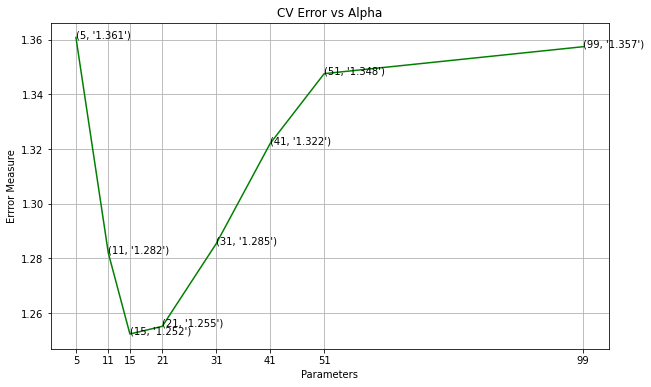

Train
Logloss (Train): 0.1603297527292191 for best param: 15
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


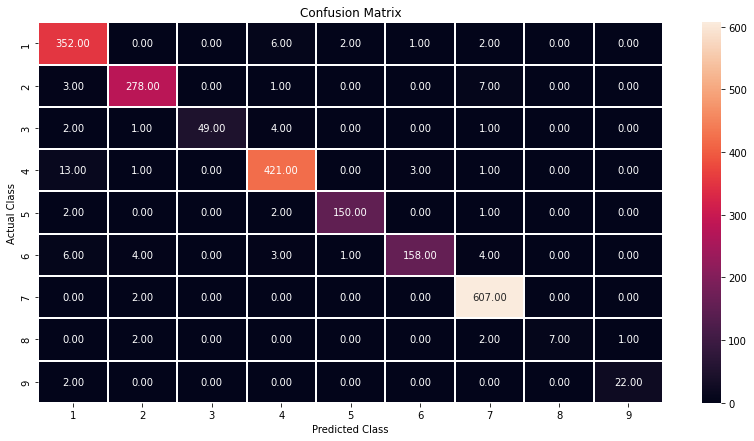

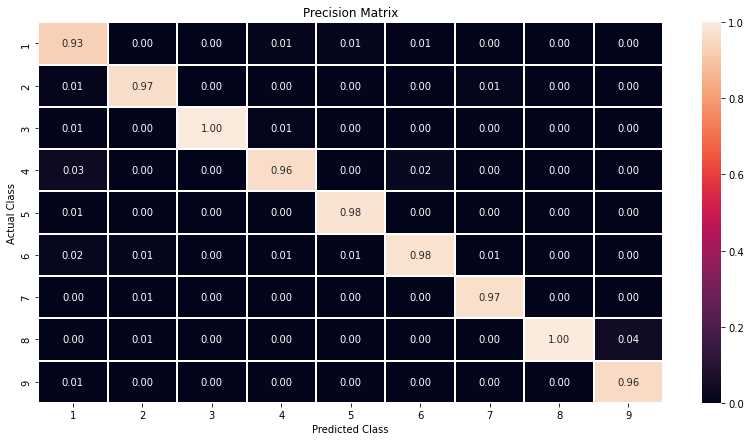

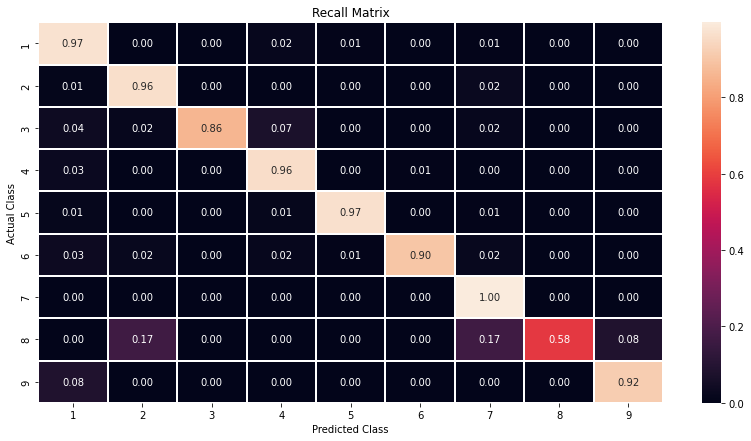

              precision    recall  f1-score   support

           1       0.93      0.97      0.95       363
           2       0.97      0.96      0.96       289
           3       1.00      0.86      0.92        57
           4       0.96      0.96      0.96       439
           5       0.98      0.97      0.97       155
           6       0.98      0.90      0.93       176
           7       0.97      1.00      0.98       609
           8       1.00      0.58      0.74        12
           9       0.96      0.92      0.94        24

    accuracy                           0.96      2124
   macro avg       0.97      0.90      0.93      2124
weighted avg       0.96      0.96      0.96      2124


Cross Validation
Logloss (CV): 1.2523703125046994 for best param: 15
Number of missclassified points in cross validation data: 0.3966165413533835
Column sum of precision matrix: [ 1.  1.  1.  1.  1.  1.  1. nan  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


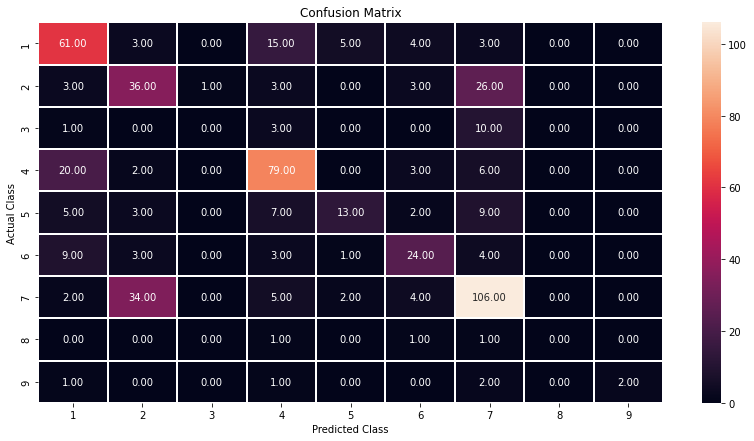

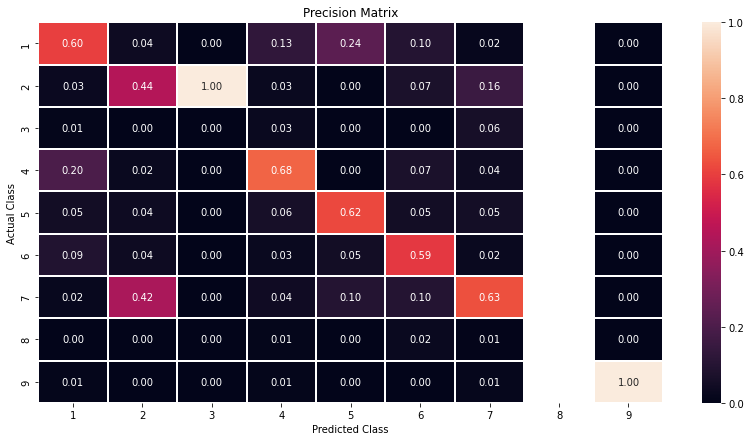

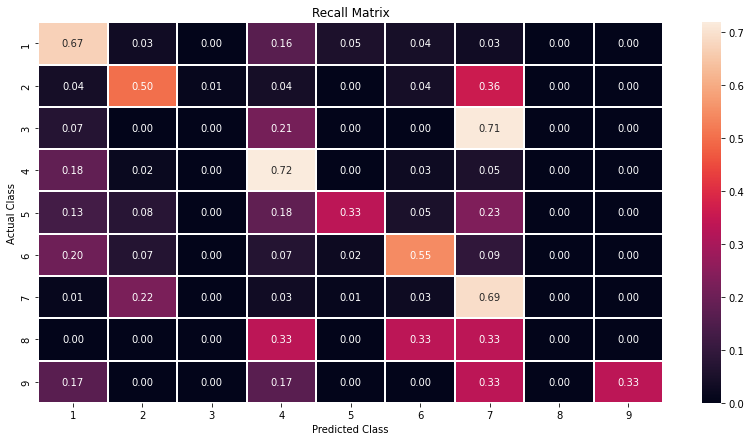

              precision    recall  f1-score   support

           1       0.60      0.67      0.63        91
           2       0.44      0.50      0.47        72
           3       0.00      0.00      0.00        14
           4       0.68      0.72      0.70       110
           5       0.62      0.33      0.43        39
           6       0.59      0.55      0.56        44
           7       0.63      0.69      0.66       153
           8       0.00      0.00      0.00         3
           9       1.00      0.33      0.50         6

    accuracy                           0.60       532
   macro avg       0.51      0.42      0.44       532
weighted avg       0.59      0.60      0.59       532


Test
Logloss (Test): 1.1176575055272655 for best param: 15
Number of missclassified points in test data: 0.4
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


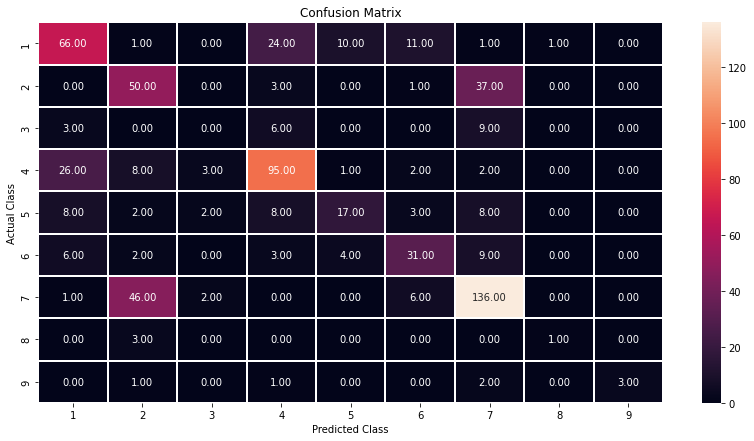

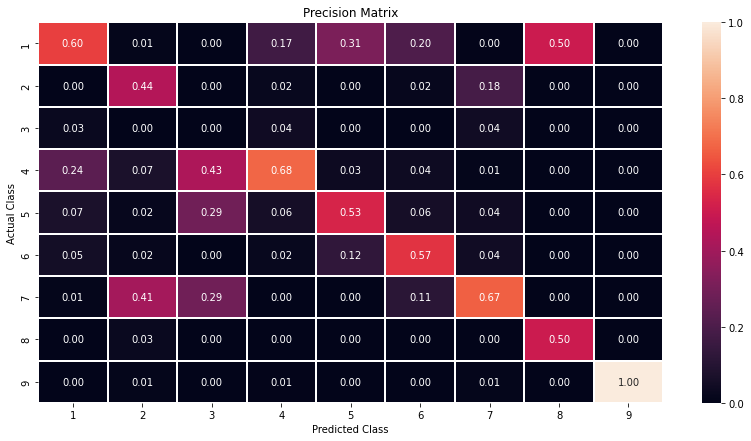

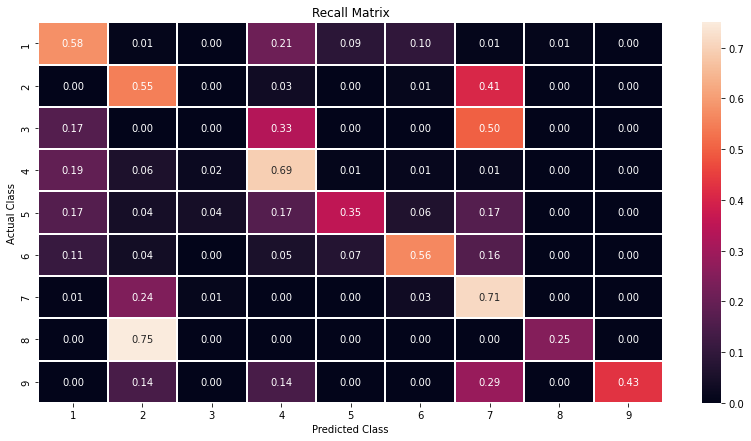

              precision    recall  f1-score   support

           1       0.60      0.58      0.59       114
           2       0.44      0.55      0.49        91
           3       0.00      0.00      0.00        18
           4       0.68      0.69      0.69       137
           5       0.53      0.35      0.42        48
           6       0.57      0.56      0.57        55
           7       0.67      0.71      0.69       191
           8       0.50      0.25      0.33         4
           9       1.00      0.43      0.60         7

    accuracy                           0.60       665
   macro avg       0.55      0.46      0.49       665
weighted avg       0.59      0.60      0.59       665



In [104]:
neighbor_params = [5, 11, 15, 21, 31, 41, 51, 99]

knn_clf, knn_sig_clf, knn_best_param = build_classifier_model(X_train=X_train_rc,
                                                              X_cv=X_cv_rc,
                                                              X_test=X_test_rc,
                                                              y_train=y_train,
                                                              y_cv=y_cv,
                                                              y_test=y_test,
                                                              model_type='knn',
                                                              hparams=neighbor_params,
                                                              logify=False)

In [105]:
check_model_knn_perf(X_test=X_test_rc,
                     y_test=y_test,
                     y_train=y_train,
                     x_q_ind=1,
                     clf=knn_clf,
                     sig_clf=knn_sig_clf,
                     best_param=knn_best_param)

Predicted Class: [5]
Actual Class: 5
The 15 nearest neighbours of the test points belongs to classes [6 1 5 6 5 5 5 5 5 5 5 5 5 5 5].
Fequency of nearest points: Counter({5: 12, 6: 2, 1: 1}).


In [106]:
check_model_knn_perf(X_test=X_test_rc,
                     y_test=y_test,
                     y_train=y_train,
                     x_q_ind=32,
                     clf=knn_clf,
                     sig_clf=knn_sig_clf,
                     best_param=knn_best_param)

Predicted Class: [4]
Actual Class: 5
The 15 nearest neighbours of the test points belongs to classes [6 1 4 1 4 3 4 1 1 1 6 5 5 4 4].
Fequency of nearest points: Counter({1: 5, 4: 5, 6: 2, 5: 2, 3: 1}).


Model Development - Logistic Regression and Linear SVM

In [107]:
def build_linear_model(X_train,
                       X_cv,
                       X_test,
                       y_train,
                       y_cv,
                       y_test,
                       loss_type,
                       hparams,
                       balancing=False,
                       logify=False):
    """
    This function builds the linear model.
    """
    log_error_list = list()
    loss_df = pd.DataFrame()
    
    pbd = 'balanced' if balancing else None
    
    for i in hparams:
        clf = SGDClassifier(loss=loss_type, alpha=i, class_weight=pbd, random_state=42)
        clf.fit(X=X_train, y=y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        sig_clf_probs = sig_clf.predict_proba(X=X_cv)
        lloss = log_loss(y_true=y_cv, y_pred=sig_clf_probs, eps=1e-15)
        log_error_list.append(lloss)
    
    print("Hyperparameter Tuning")
    loss_df['alpha'] = hparams
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    hparams_logs = np.log10(hparams) if logify else hparams
    
    plt.figure(figsize=(10, 6))
    plt.plot(hparams_logs, log_error_list, c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(text=(hparams[i], str(txt)), xy=(hparams_logs[i], log_error_list[i]))
    plt.xticks(hparams_logs)
    plt.title(label='CV Error vs Alpha')
    plt.xlabel("Parameters")
    plt.ylabel('Errror Measure')
    plt.grid()
    plt.show()
    
    best_param = hparams[np.argmin(log_error_list)]
    clf = SGDClassifier(loss=loss_type, alpha=best_param, class_weight=pbd, random_state=42)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best param: {}".format(train_loss, best_param))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best param: {}".format(cv_loss, best_param))
    miss_cv = np.count_nonzero(a=(cv_cm_pred - y_cv)) / (y_cv.shape[0])
    print("Number of missclassified points in cross validation data: {}".format(miss_cv))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best param: {}".format(test_loss, best_param))
    miss_test = np.count_nonzero(a=(test_cm_pred - y_test)) / (y_test.shape[0])
    print("Number of missclassified points in test data: {}".format(miss_test))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))
    
    return clf, sig_clf

Logistic Regression - Balanced

Hyperparameter Tuning


alpha   logloss
0    0.000001  1.620606
1    0.000010  1.591933
2    0.000100  1.413867
3    0.001000  1.391917
4    0.010000  1.499314
5    0.100000  1.728714
6    1.000000  1.801056
7   10.000000  1.808448
8  100.000000  1.809176

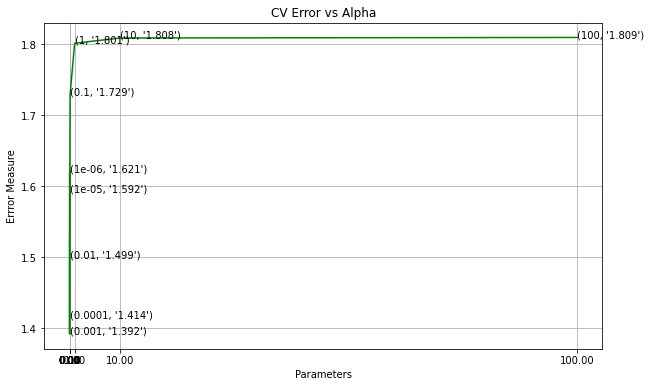

Train
Logloss (Train): 0.527546333130796 for best param: 0.001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


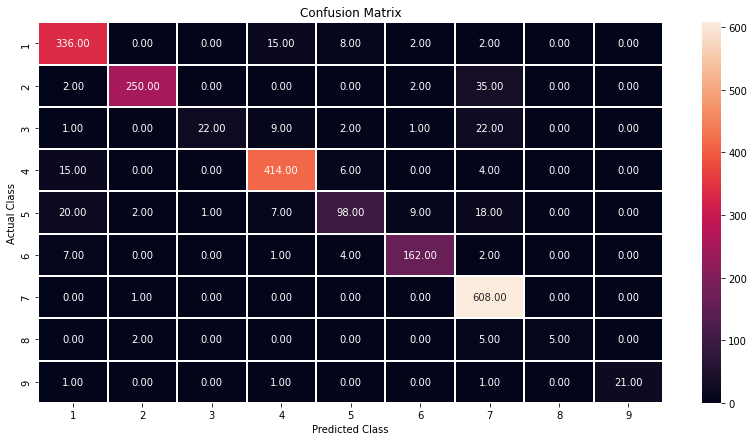

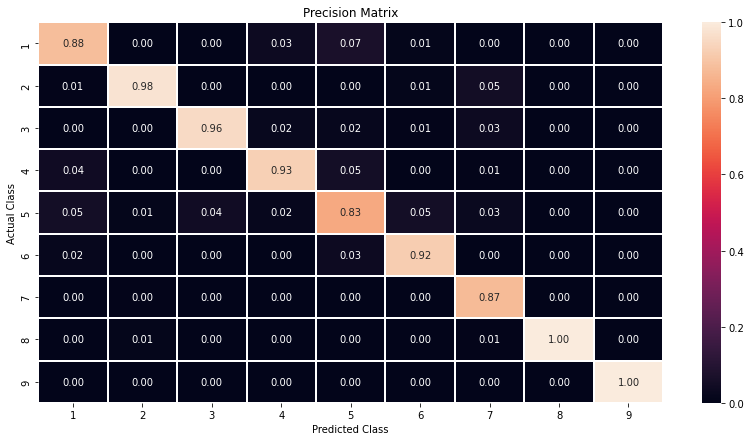

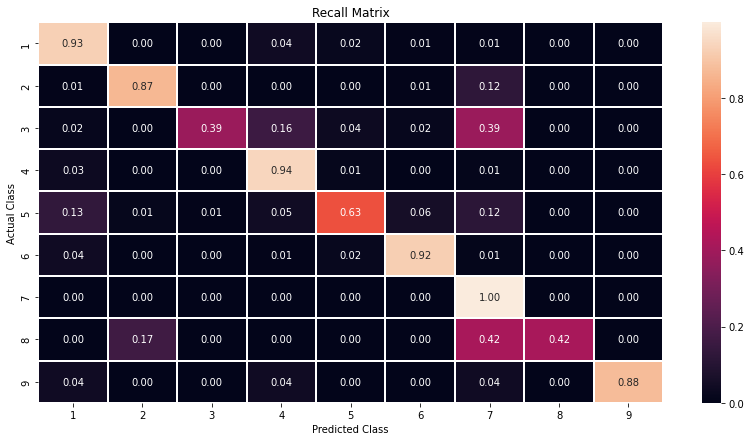

              precision    recall  f1-score   support

           1       0.88      0.93      0.90       363
           2       0.98      0.87      0.92       289
           3       0.96      0.39      0.55        57
           4       0.93      0.94      0.93       439
           5       0.83      0.63      0.72       155
           6       0.92      0.92      0.92       176
           7       0.87      1.00      0.93       609
           8       1.00      0.42      0.59        12
           9       1.00      0.88      0.93        24

    accuracy                           0.90      2124
   macro avg       0.93      0.77      0.82      2124
weighted avg       0.90      0.90      0.90      2124


Cross Validation
Logloss (CV): 1.3919168852078292 for best param: 0.001
Number of missclassified points in cross validation data: 0.42857142857142855
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


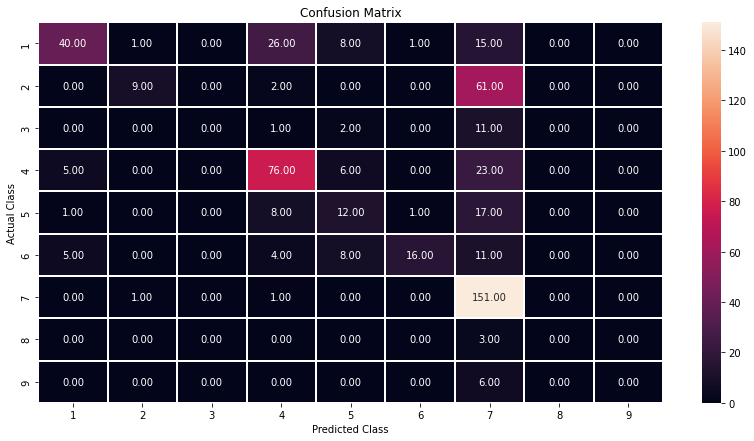

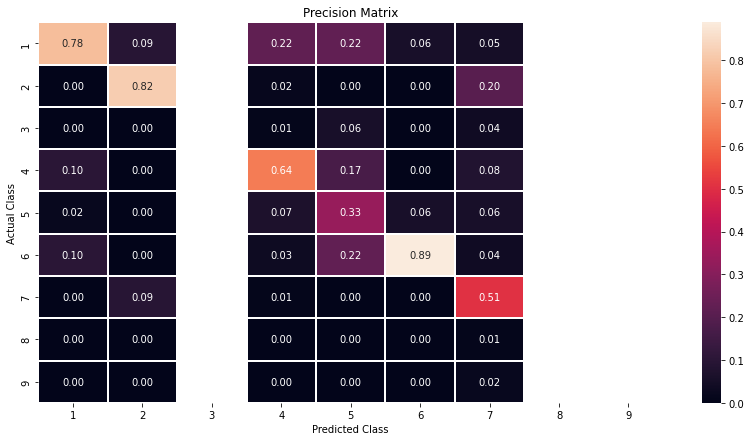

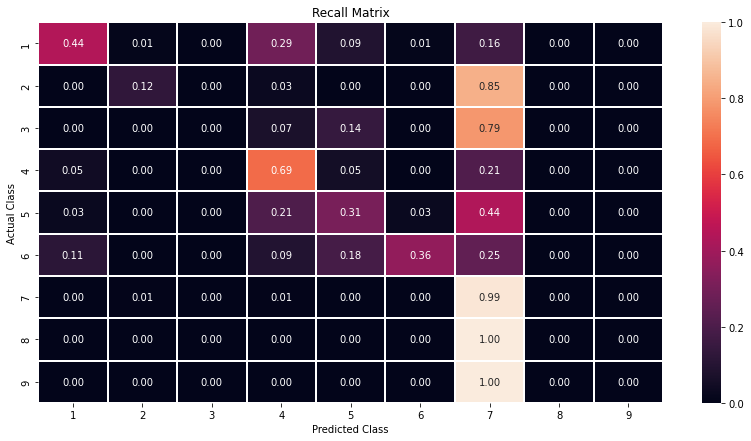

              precision    recall  f1-score   support

           1       0.78      0.44      0.56        91
           2       0.82      0.12      0.22        72
           3       0.00      0.00      0.00        14
           4       0.64      0.69      0.67       110
           5       0.33      0.31      0.32        39
           6       0.89      0.36      0.52        44
           7       0.51      0.99      0.67       153
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6

    accuracy                           0.57       532
   macro avg       0.44      0.32      0.33       532
weighted avg       0.62      0.57      0.52       532


Test
Logloss (Test): 1.3989241513144346 for best param: 0.001
Number of missclassified points in test data: 0.4255639097744361
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


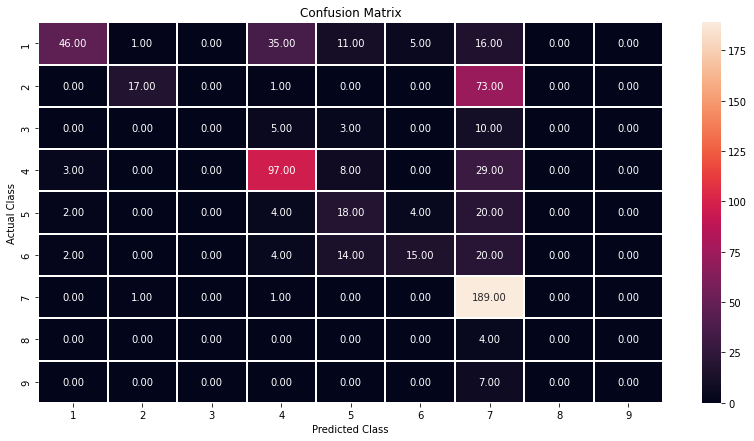

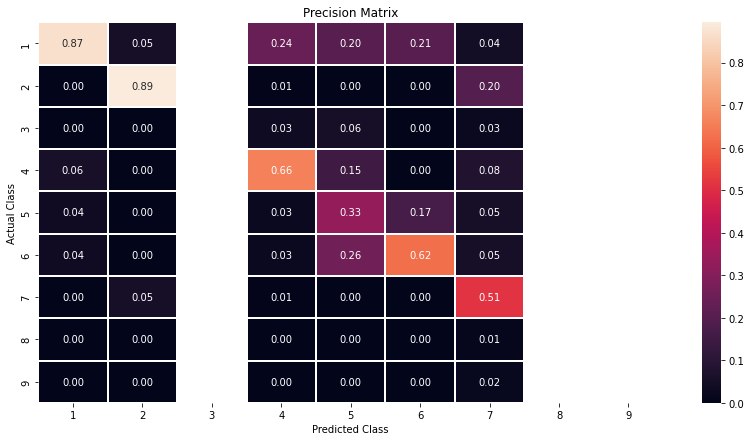

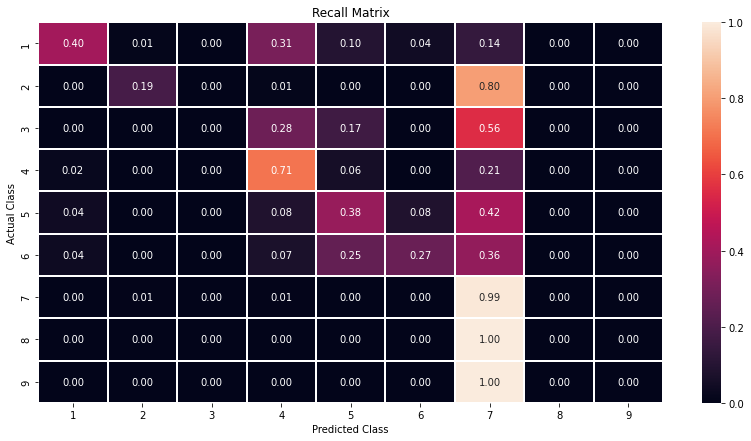

              precision    recall  f1-score   support

           1       0.87      0.40      0.55       114
           2       0.89      0.19      0.31        91
           3       0.00      0.00      0.00        18
           4       0.66      0.71      0.68       137
           5       0.33      0.38      0.35        48
           6       0.62      0.27      0.38        55
           7       0.51      0.99      0.68       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.57       665
   macro avg       0.43      0.33      0.33       665
weighted avg       0.63      0.57      0.53       665



In [108]:
alpha_params = [10 ** x for x in range(-6, 3)]

lr_clf, lr_sig_clf = build_linear_model(X_train=X_train_oh,
                                        X_cv=X_cv_oh,
                                        X_test=X_test_oh,
                                        y_train=y_train,
                                        y_cv=y_cv,
                                        y_test=y_test,
                                        loss_type='log_loss',
                                        hparams=alpha_params,
                                        logify=False,
                                        balancing=True)

In [109]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=1,
                    n_feature_nums=100,
                    clf=lr_clf,
                    sig_clf=lr_sig_clf,
                    model=None)

Predicted Class: [5]
Predicted Class Probabilities: [[0.2303 0.0774 0.0263 0.0572 0.3569 0.1542 0.0812 0.0073 0.0092]]
Actual Class: 5
0 --> Gene feature [brca1] present in test data point: True
Out of the top 100 features 1 feature(s) are present in the query point.


In [110]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=99,
                    n_feature_nums=100,
                    clf=lr_clf,
                    sig_clf=lr_sig_clf,
                    model=None)

Predicted Class: [7]
Predicted Class Probabilities: [[0.1265 0.1539 0.0366 0.1246 0.0675 0.0731 0.3995 0.0078 0.0106]]
Actual Class: 7
21 --> Gene feature [flt3] present in test data point: True
82 --> Text feature [constitutive] present in test data: True
Out of the top 100 features 2 feature(s) are present in the query point.


Logistic Regression - Imbalanced

Hyperparameter Tuning


alpha   logloss
0    0.000001  1.615255
1    0.000010  1.583496
2    0.000100  1.421872
3    0.001000  1.391898
4    0.010000  1.469947
5    0.100000  1.650620
6    1.000000  1.760803
7   10.000000  1.776277
8  100.000000  1.777884

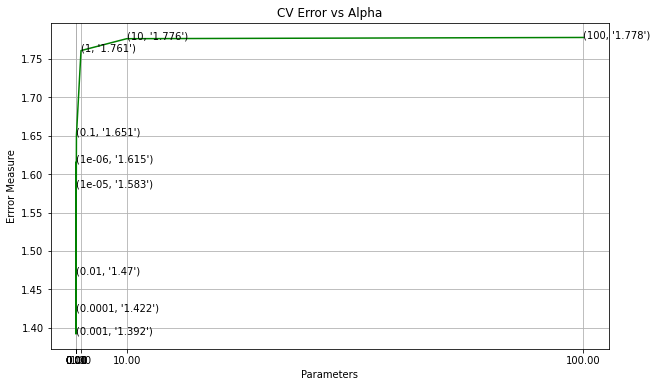

Train
Logloss (Train): 0.5226623978679521 for best param: 0.001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


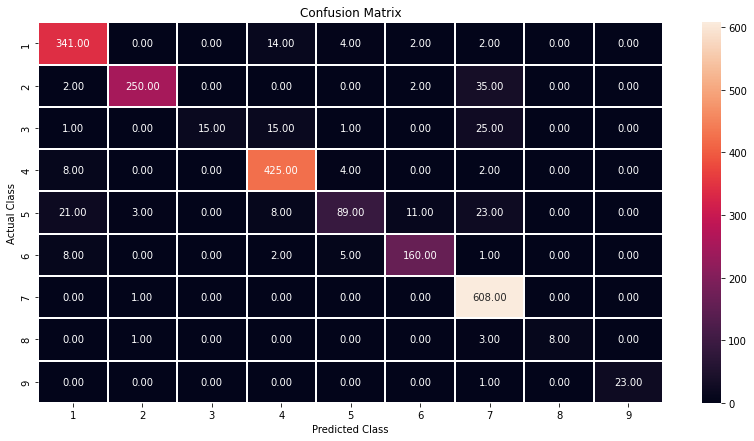

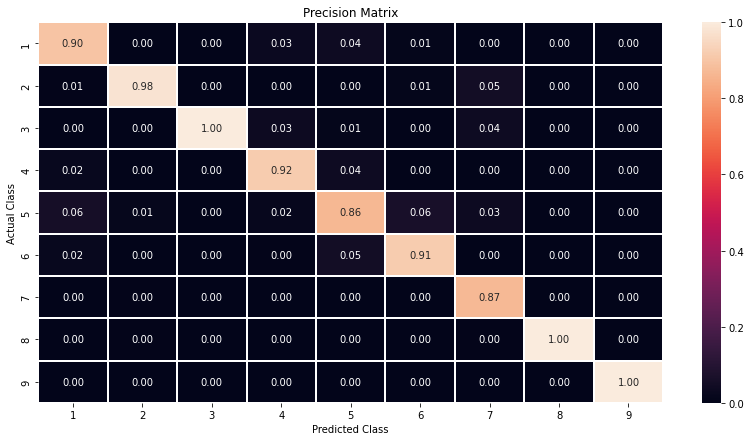

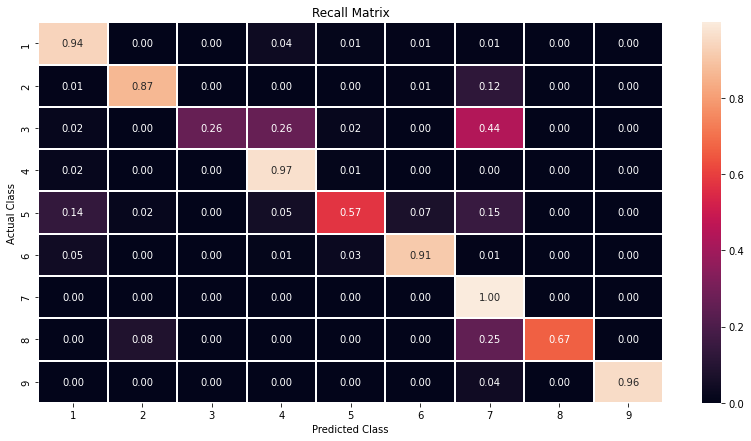

              precision    recall  f1-score   support

           1       0.90      0.94      0.92       363
           2       0.98      0.87      0.92       289
           3       1.00      0.26      0.42        57
           4       0.92      0.97      0.94       439
           5       0.86      0.57      0.69       155
           6       0.91      0.91      0.91       176
           7       0.87      1.00      0.93       609
           8       1.00      0.67      0.80        12
           9       1.00      0.96      0.98        24

    accuracy                           0.90      2124
   macro avg       0.94      0.79      0.83      2124
weighted avg       0.91      0.90      0.90      2124


Cross Validation
Logloss (CV): 1.3918984385141706 for best param: 0.001
Number of missclassified points in cross validation data: 0.41729323308270677
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


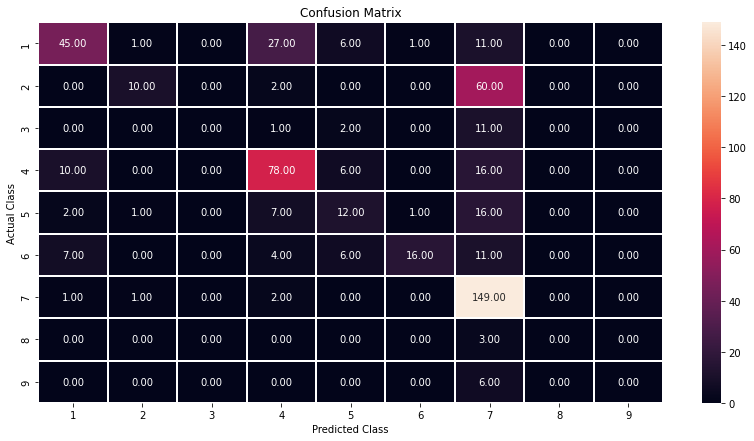

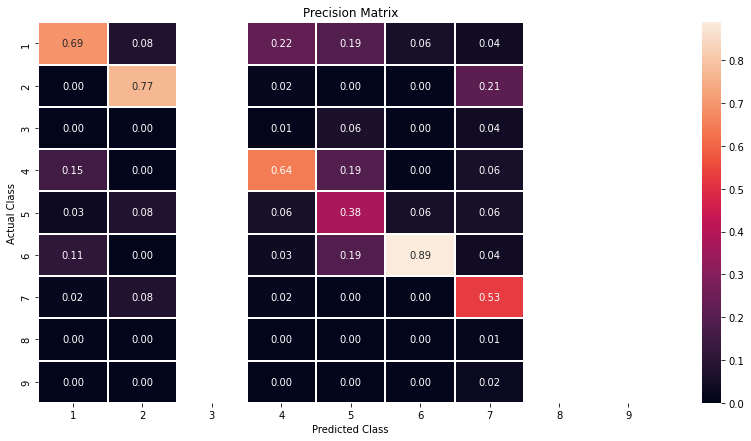

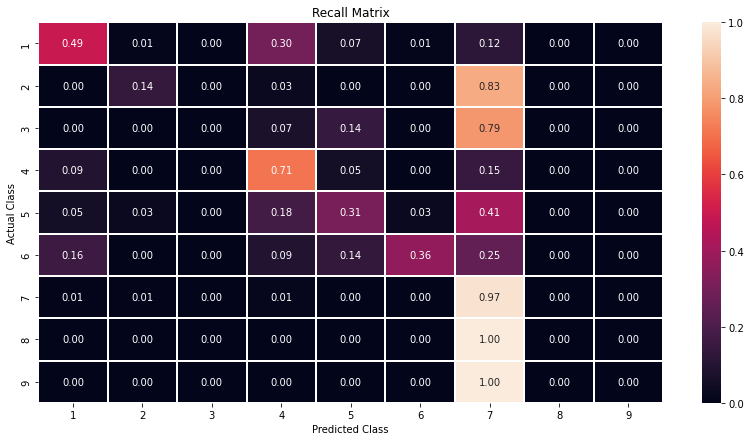

              precision    recall  f1-score   support

           1       0.69      0.49      0.58        91
           2       0.77      0.14      0.24        72
           3       0.00      0.00      0.00        14
           4       0.64      0.71      0.68       110
           5       0.38      0.31      0.34        39
           6       0.89      0.36      0.52        44
           7       0.53      0.97      0.68       153
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6

    accuracy                           0.58       532
   macro avg       0.43      0.33      0.34       532
weighted avg       0.61      0.58      0.53       532


Test
Logloss (Test): 1.4020937633978328 for best param: 0.001
Number of missclassified points in test data: 0.4105263157894737
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


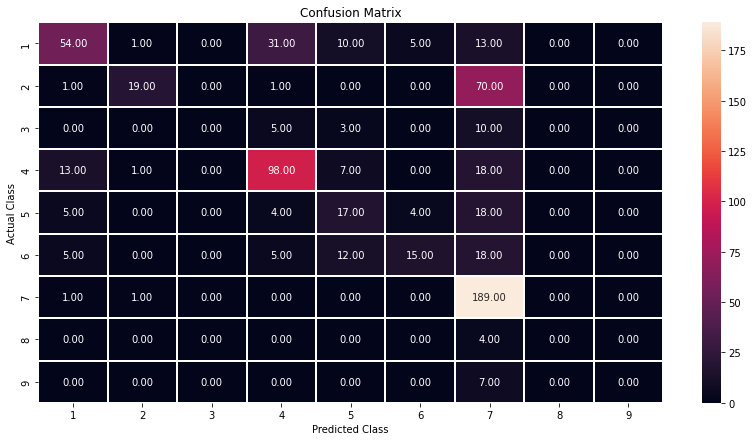

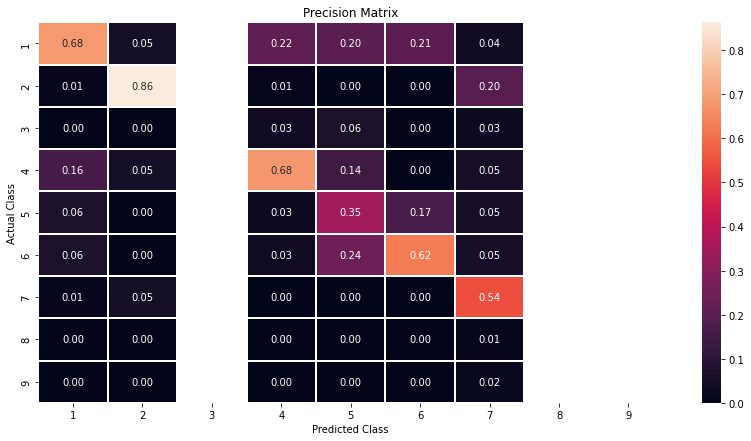

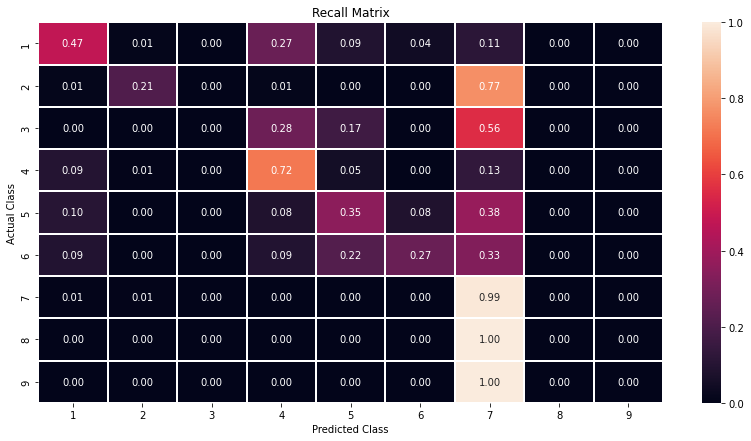

              precision    recall  f1-score   support

           1       0.68      0.47      0.56       114
           2       0.86      0.21      0.34        91
           3       0.00      0.00      0.00        18
           4       0.68      0.72      0.70       137
           5       0.35      0.35      0.35        48
           6       0.62      0.27      0.38        55
           7       0.54      0.99      0.70       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.59       665
   macro avg       0.42      0.33      0.34       665
weighted avg       0.61      0.59      0.54       665



In [111]:
alpha_params = [10 ** x for x in range(-6, 3)]

lr_clf, lr_sig_clf = build_linear_model(X_train=X_train_oh,
                                        X_cv=X_cv_oh,
                                        X_test=X_test_oh,
                                        y_train=y_train,
                                        y_cv=y_cv,
                                        y_test=y_test,
                                        loss_type='log_loss',
                                        hparams=alpha_params,
                                        logify=False,
                                        balancing=False)

In [112]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=1,
                    n_feature_nums=100,
                    clf=lr_clf,
                    sig_clf=lr_sig_clf,
                    model=None)

Predicted Class: [5]
Predicted Class Probabilities: [[0.2423 0.076  0.0313 0.0461 0.3582 0.1513 0.0743 0.0089 0.0117]]
Actual Class: 5
0 --> Gene feature [brca1] present in test data point: True
Out of the top 100 features 1 feature(s) are present in the query point.


In [113]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=99,
                    n_feature_nums=100,
                    clf=lr_clf,
                    sig_clf=lr_sig_clf,
                    model=None)

Predicted Class: [7]
Predicted Class Probabilities: [[0.1212 0.1538 0.0474 0.1128 0.0776 0.0805 0.3707 0.0136 0.0226]]
Actual Class: 7
19 --> Gene feature [flt3] present in test data point: True
Out of the top 100 features 1 feature(s) are present in the query point.


Linear SVM - Balanced

Hyperparameter Tuning


alpha   logloss
0    0.000001  1.607995
1    0.000010  1.590676
2    0.000100  1.500929
3    0.001000  1.431741
4    0.010000  1.471952
5    0.100000  1.686714
6    1.000000  1.806134
7   10.000000  1.809296
8  100.000000  1.809297

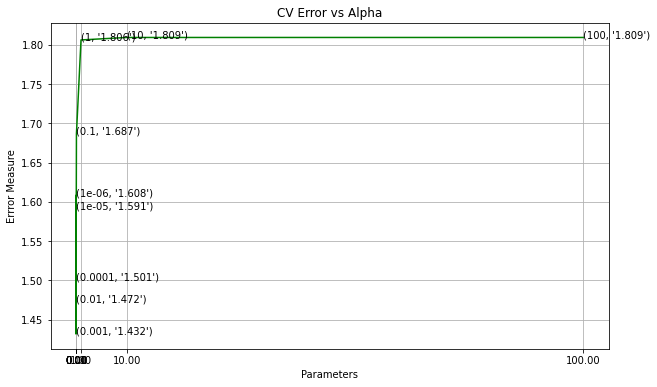

Train
Logloss (Train): 0.5345915591634833 for best param: 0.001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


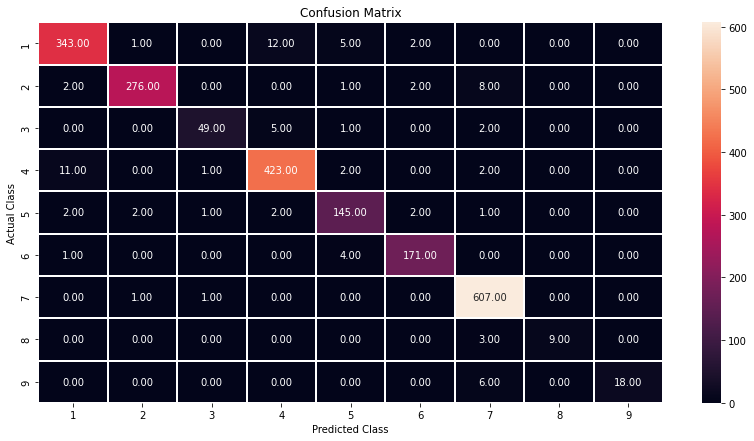

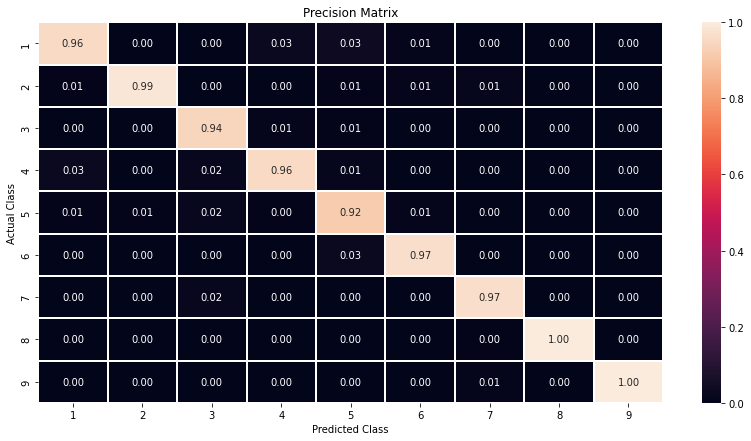

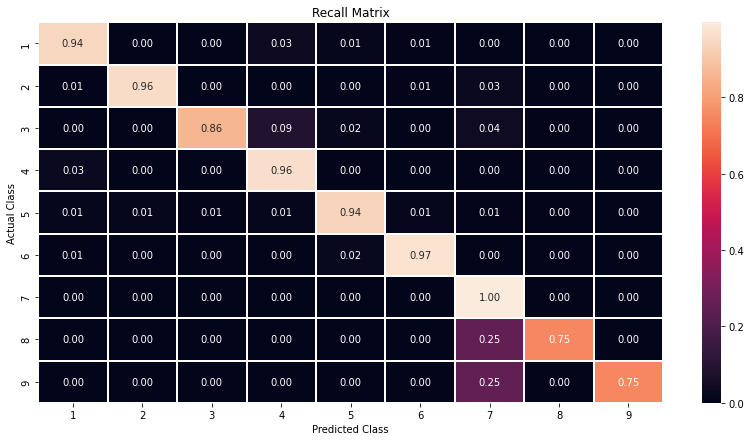

              precision    recall  f1-score   support

           1       0.96      0.94      0.95       363
           2       0.99      0.96      0.97       289
           3       0.94      0.86      0.90        57
           4       0.96      0.96      0.96       439
           5       0.92      0.94      0.93       155
           6       0.97      0.97      0.97       176
           7       0.97      1.00      0.98       609
           8       1.00      0.75      0.86        12
           9       1.00      0.75      0.86        24

    accuracy                           0.96      2124
   macro avg       0.97      0.90      0.93      2124
weighted avg       0.96      0.96      0.96      2124


Cross Validation
Logloss (CV): 1.4317414361348462 for best param: 0.001
Number of missclassified points in cross validation data: 0.42105263157894735
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


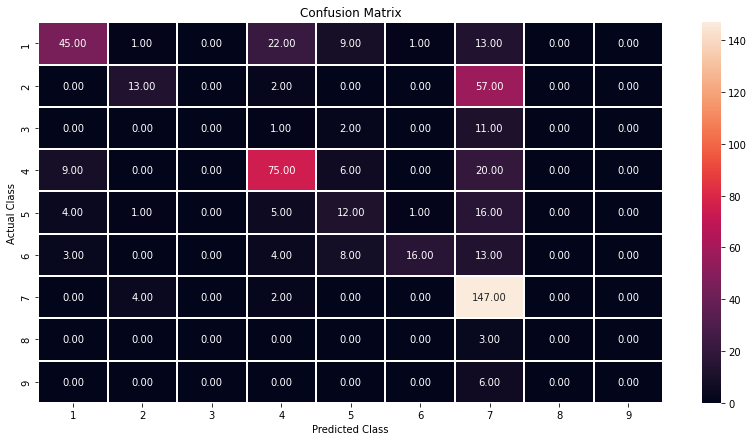

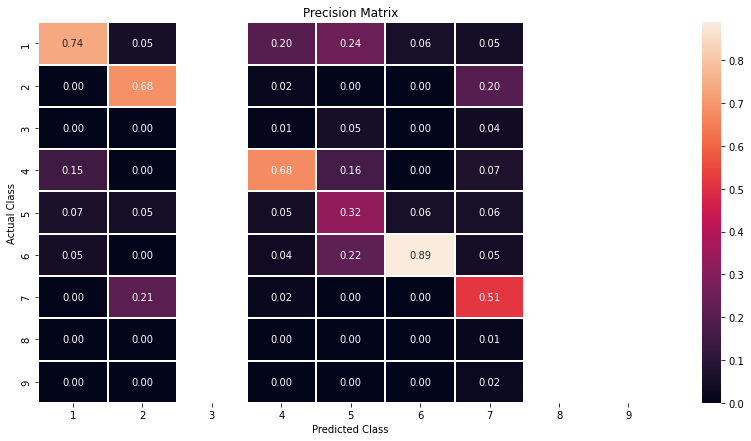

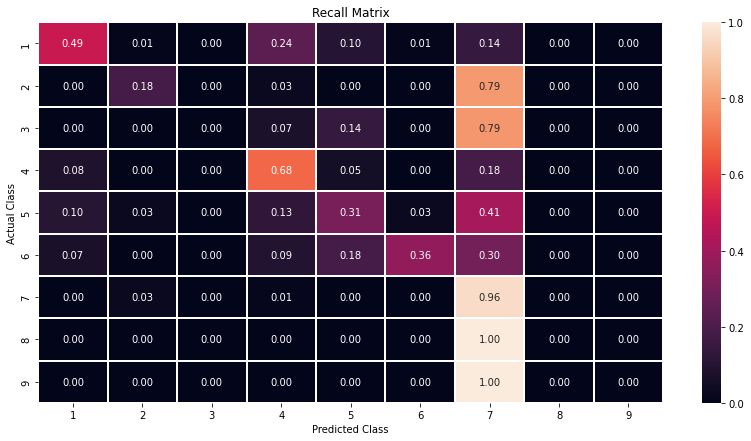

              precision    recall  f1-score   support

           1       0.74      0.49      0.59        91
           2       0.68      0.18      0.29        72
           3       0.00      0.00      0.00        14
           4       0.68      0.68      0.68       110
           5       0.32      0.31      0.32        39
           6       0.89      0.36      0.52        44
           7       0.51      0.96      0.67       153
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6

    accuracy                           0.58       532
   macro avg       0.42      0.33      0.34       532
weighted avg       0.60      0.58      0.54       532


Test
Logloss (Test): 1.457458238118775 for best param: 0.001
Number of missclassified points in test data: 0.4255639097744361
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


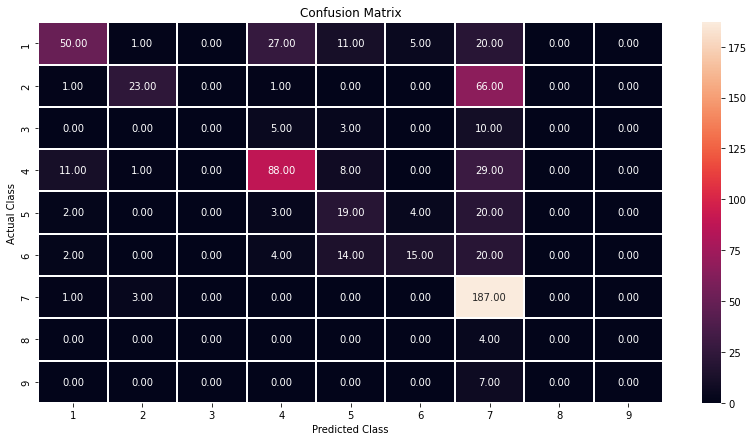

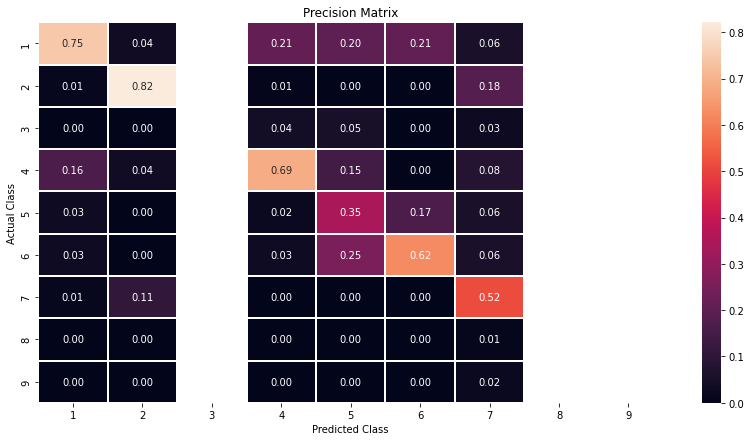

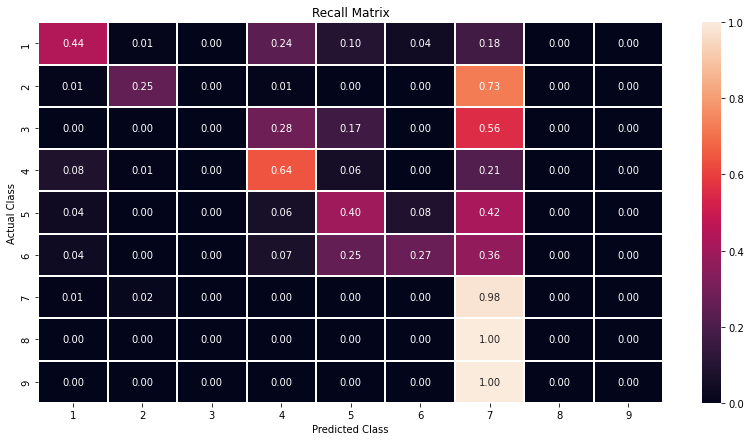

              precision    recall  f1-score   support

           1       0.75      0.44      0.55       114
           2       0.82      0.25      0.39        91
           3       0.00      0.00      0.00        18
           4       0.69      0.64      0.66       137
           5       0.35      0.40      0.37        48
           6       0.62      0.27      0.38        55
           7       0.52      0.98      0.68       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.57       665
   macro avg       0.42      0.33      0.34       665
weighted avg       0.61      0.57      0.54       665



In [114]:
alpha_params = [10 ** x for x in range(-6, 3)]

svm_clf, svm_sig_clf = build_linear_model(X_train=X_train_oh,
                                          X_cv=X_cv_oh,
                                          X_test=X_test_oh,
                                          y_train=y_train,
                                          y_cv=y_cv,
                                          y_test=y_test,
                                          loss_type='hinge',
                                          hparams=alpha_params,
                                          logify=False,
                                          balancing=True)

In [115]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=1,
                    n_feature_nums=100,
                    clf=svm_clf,
                    sig_clf=svm_sig_clf,
                    model=None)

Predicted Class: [5]
Predicted Class Probabilities: [[0.1639 0.095  0.011  0.0161 0.4424 0.1112 0.1484 0.0061 0.0059]]
Actual Class: 5
0 --> Gene feature [brca1] present in test data point: True
Out of the top 100 features 1 feature(s) are present in the query point.


In [116]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=99,
                    n_feature_nums=100,
                    clf=svm_clf,
                    sig_clf=svm_sig_clf,
                    model=None)

Predicted Class: [7]
Predicted Class Probabilities: [[0.1396 0.1654 0.0335 0.1259 0.0743 0.0771 0.3698 0.0074 0.0071]]
Actual Class: 7
60 --> Gene feature [flt3] present in test data point: True
Out of the top 100 features 1 feature(s) are present in the query point.


Linear SVM - Imbalanced

Hyperparameter Tuning


alpha   logloss
0    0.000001  1.618543
1    0.000010  1.590588
2    0.000100  1.494220
3    0.001000  1.428896
4    0.010000  1.450048
5    0.100000  1.606212
6    1.000000  1.774648
7   10.000000  1.778131
8  100.000000  1.778131

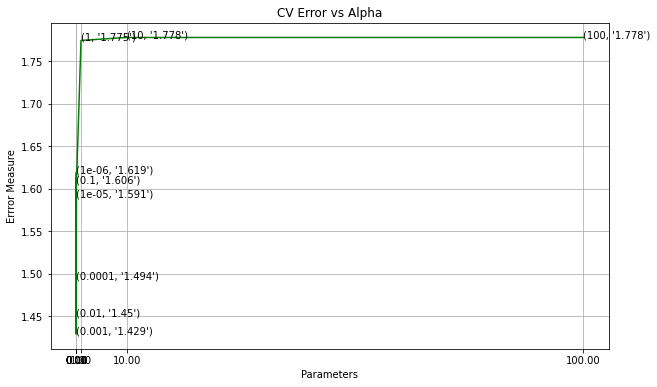

Train
Logloss (Train): 0.5126455821921999 for best param: 0.001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


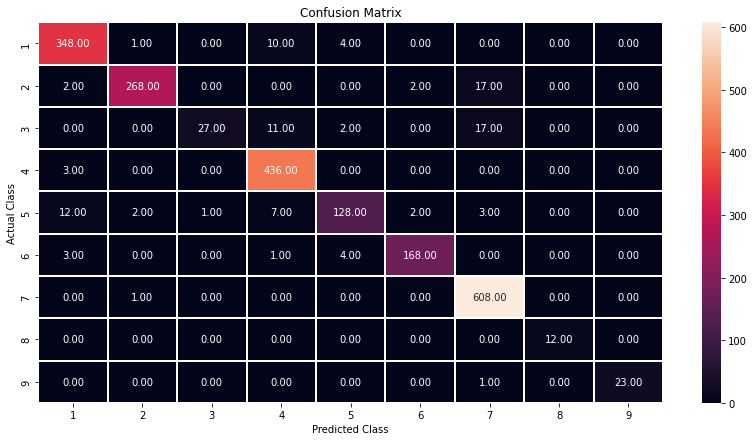

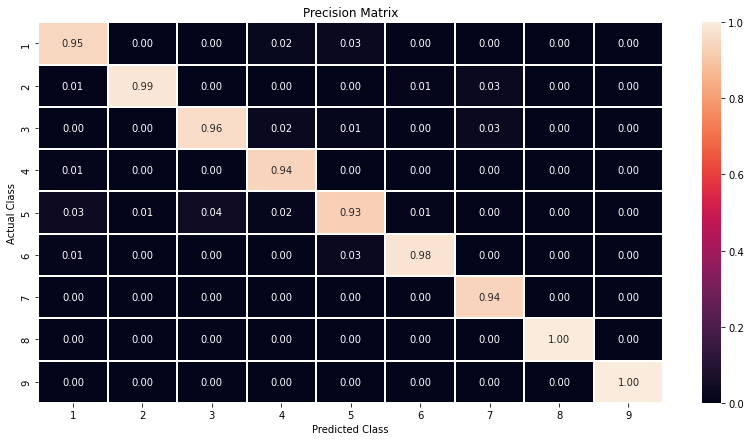

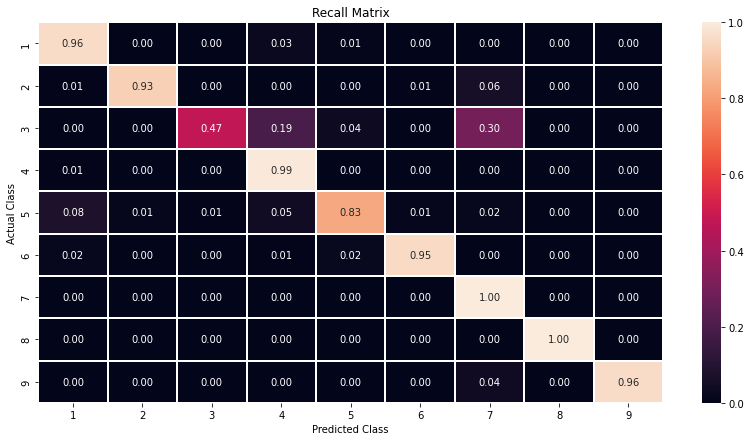

              precision    recall  f1-score   support

           1       0.95      0.96      0.95       363
           2       0.99      0.93      0.96       289
           3       0.96      0.47      0.64        57
           4       0.94      0.99      0.96       439
           5       0.93      0.83      0.87       155
           6       0.98      0.95      0.97       176
           7       0.94      1.00      0.97       609
           8       1.00      1.00      1.00        12
           9       1.00      0.96      0.98        24

    accuracy                           0.95      2124
   macro avg       0.96      0.90      0.92      2124
weighted avg       0.95      0.95      0.95      2124


Cross Validation
Logloss (CV): 1.4288957463489929 for best param: 0.001
Number of missclassified points in cross validation data: 0.4266917293233083
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


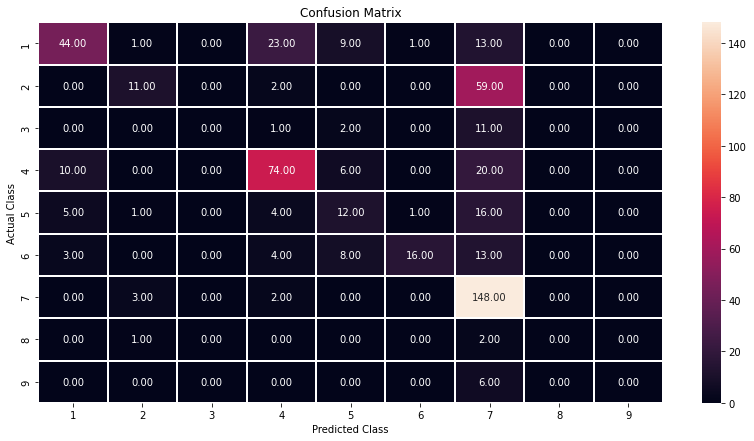

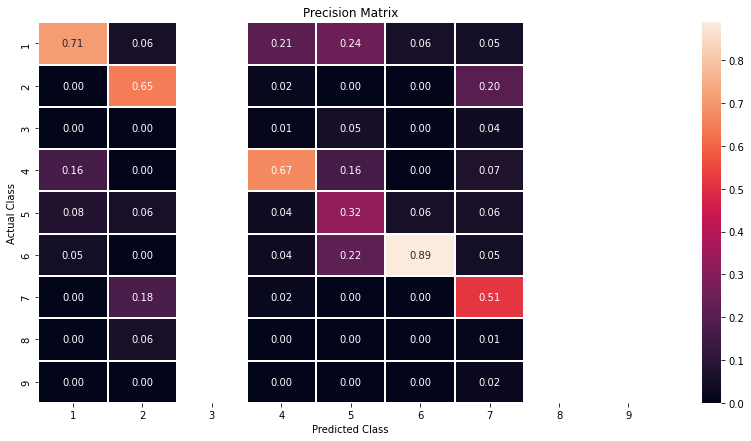

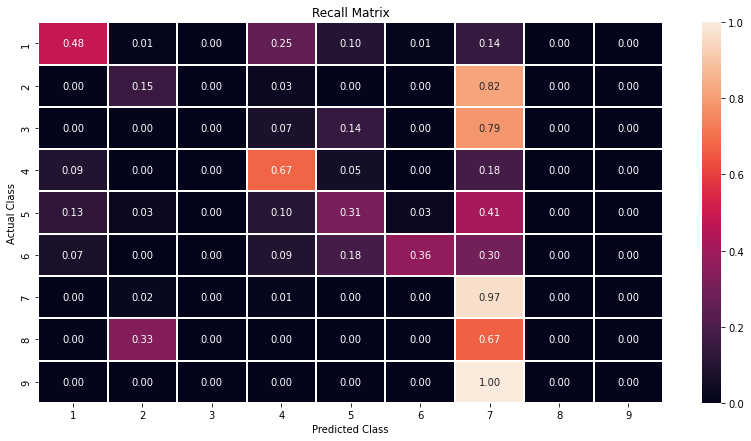

              precision    recall  f1-score   support

           1       0.71      0.48      0.58        91
           2       0.65      0.15      0.25        72
           3       0.00      0.00      0.00        14
           4       0.67      0.67      0.67       110
           5       0.32      0.31      0.32        39
           6       0.89      0.36      0.52        44
           7       0.51      0.97      0.67       153
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6

    accuracy                           0.57       532
   macro avg       0.42      0.33      0.33       532
weighted avg       0.59      0.57      0.53       532


Test
Logloss (Test): 1.4551277072539899 for best param: 0.001
Number of missclassified points in test data: 0.4345864661654135
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1. nan nan]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


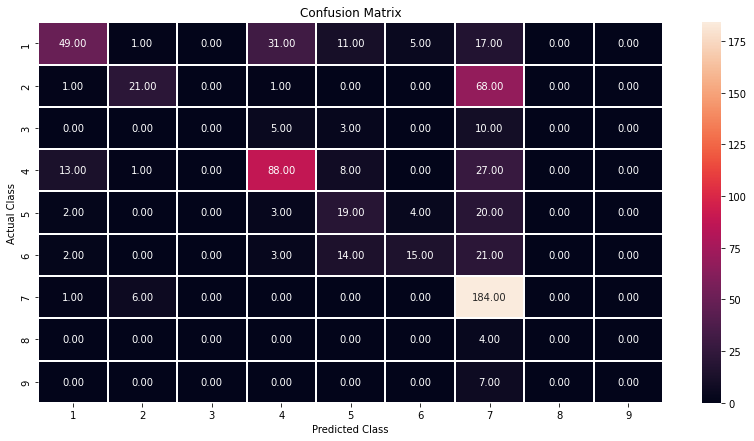

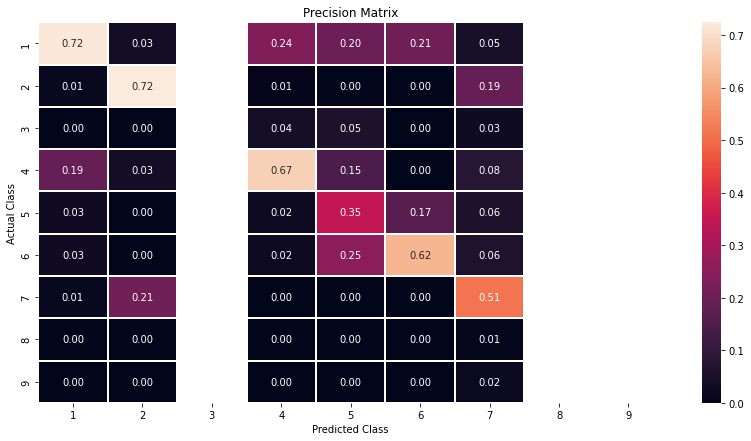

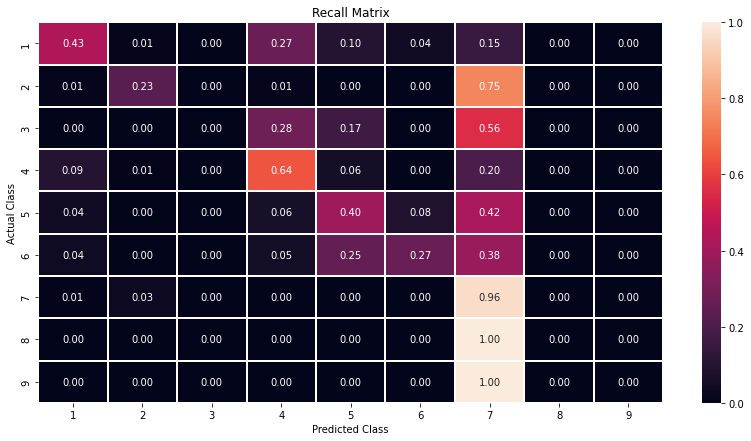

              precision    recall  f1-score   support

           1       0.72      0.43      0.54       114
           2       0.72      0.23      0.35        91
           3       0.00      0.00      0.00        18
           4       0.67      0.64      0.66       137
           5       0.35      0.40      0.37        48
           6       0.62      0.27      0.38        55
           7       0.51      0.96      0.67       191
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7

    accuracy                           0.57       665
   macro avg       0.40      0.33      0.33       665
weighted avg       0.59      0.57      0.53       665



In [117]:
alpha_params = [10 ** x for x in range(-6, 3)]

svm_clf, svm_sig_clf = build_linear_model(X_train=X_train_oh,
                                          X_cv=X_cv_oh,
                                          X_test=X_test_oh,
                                          y_train=y_train,
                                          y_cv=y_cv,
                                          y_test=y_test,
                                          loss_type='hinge',
                                          hparams=alpha_params,
                                          logify=False,
                                          balancing=False)

In [118]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=1,
                    n_feature_nums=100,
                    clf=svm_clf,
                    sig_clf=svm_sig_clf,
                    model=None)

Predicted Class: [5]
Predicted Class Probabilities: [[0.183  0.0962 0.0094 0.011  0.4475 0.1054 0.1296 0.0087 0.0093]]
Actual Class: 5
0 --> Gene feature [brca1] present in test data point: True
Out of the top 100 features 1 feature(s) are present in the query point.


In [119]:
check_model_nb_perf(df=test_df,
                    X_test=X_test_oh,
                    y_test=y_test,
                    x_q_ind=99,
                    n_feature_nums=100,
                    clf=svm_clf,
                    sig_clf=svm_sig_clf,
                    model=None)

Predicted Class: [7]
Predicted Class Probabilities: [[0.1347 0.1616 0.0377 0.1222 0.0799 0.0795 0.3642 0.0098 0.0105]]
Actual Class: 7
Out of the top 100 features 0 feature(s) are present in the query point.
